#### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import choice
from numpy.linalg import norm

from math import factorial

from itertools import permutations

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from tqdm import tqdm
import os

In [3]:
from numpy.linalg import svd, eigvals
from sklearn.preprocessing import StandardScaler

In [83]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, homogeneity_completeness_v_measure, confusion_matrix, ConfusionMatrixDisplay, homogeneity_score

In [5]:
from skdim.id import *

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

In [8]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [9]:
from generate_data import generate_binary_rep_data, makeTensorLoaders

#### Test for CUDA

In [10]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


### Model Training

#### Number of runs

In [11]:
nRuns = 5

#### Generate data for runs

In [12]:
dim = 16
nTot = 5000

fracTrain = 0.8
fracTest = np.round(1-fracTrain,2)

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

lenSeq = 4
nRepeats = 2

In [13]:
numM = 2**dim-1

In [14]:
repsTrain = {}
yRepsTrain = {}
eTrain = {}
pTrain = {}
surpTrain = {}
allStatesTrain = {}

In [15]:
repsTest = {}
yRepsTest = {}
eTest = {}
pTest = {}
surpTest = {}
allStatesTest = {}

In [16]:
repsTestTemp = {}
yRepsTestTemp = {}
eTestTemp = {}
pTestTemp = {}
surpTestTemp = {}
allStatesTestTemp = {}

In [17]:
for cntr in range(nRuns):
    (repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),\
    (repsTest[cntr],yRepsTest[cntr],eTest[cntr],surpTest[cntr]),\
    (repsTestTemp[cntr],yRepsTestTemp[cntr],eTestTemp[cntr],surpTestTemp[cntr]),\
    (allStatesTrain[cntr],allStatesTest[cntr],allStatesTestTemp[cntr]) = generate_binary_rep_data(nTot,fracTrain,dim,lenSeq)

In [18]:
labelsTrain = {}
labelsTest = {}
labelsTestTemp = {}

In [19]:
for cntr in range(nRuns):
    (repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),\
    (repsTest[cntr],yRepsTest[cntr],eTest[cntr],surpTest[cntr]),\
    (repsTestTemp[cntr],yRepsTestTemp[cntr],eTestTemp[cntr],surpTestTemp[cntr]),\
    (allStatesTrain[cntr],allStatesTest[cntr],allStatesTestTemp[cntr]) = generate_binary_rep_data(nTot,fracTrain,dim,lenSeq)

In [20]:
for cntr in range(nRuns):
    labelsTrain[cntr] = np.repeat(allStatesTrain[cntr][:,:-1],2).reshape(nTrain,-1)
    labelsTest[cntr] = np.repeat(allStatesTest[cntr][:,1:],2).reshape(nTest,-1)
    labelsTestTemp[cntr] = np.repeat(allStatesTestTemp[cntr][:,1:],2).reshape(nTest,-1)

#### Create directories to save data and representations

In [21]:
pp = ## specify path

In [22]:
npp = {}
pp_npy = {}
pp_pts = {}

In [23]:
for cntr in range(nRuns):
    
    npp[cntr] = 'binary-unidirectional-fb-'+str(cntr)+'/'
    pp_npy[cntr] = pp+npp[cntr]+'npys-'+str(cntr)+'/'
    pp_pts[cntr] = pp+npp[cntr]+'pts-'+str(cntr)+'/'
    
## uncomment the following lines to create the folders. comment out if already created
    
#     os.mkdir(os.path.join(pp,npp[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr]))
#     os.mkdir(os.path.join(pp,npp[cntr],pp_pts[cntr]))

#     os.mkdir(os.path.join(pp,npp[cntr],pp_npy[cntr],'Dataset/'))

#### Save seeds and dataset

In [24]:
seeds = np.random.randint(1000, size=nRuns)
np.save(pp_npy[cntr]+'seeds',seeds)

In [25]:
for cntr in range(nRuns):

    ## Train Data
    np.save(pp_npy[cntr]+'Dataset/repsTrain',repsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTrain',yRepsTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTrain',eTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTrain',surpTrain[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTrain',allStatesTrain[cntr])

    ## Test Data
    np.save(pp_npy[cntr]+'Dataset/repsTest',repsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTest',yRepsTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTest',eTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTest',surpTest[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTest',allStatesTest[cntr])
    
    ## Temporally violated Test Data
    np.save(pp_npy[cntr]+'Dataset/repsTestTemp',repsTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/yRepsTestTemp',yRepsTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/eTestTemp',eTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/surpTestTemp',surpTestTemp[cntr])
    np.save(pp_npy[cntr]+'Dataset/allStatesTestTemp',allStatesTestTemp[cntr])

#### Load seeds

In [26]:
seeds = np.load(pp_npy[cntr]+'seeds.npy')

#### Convert data into tensors, etc.

In [27]:
batch_size = 100 ##100

In [28]:
pos_seq_idx = np.array([0,0,1,1,2,2])

In [29]:
train_loader = {}
test_loader = {}
test_temp_loader = {}

In [30]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),
                                           batch_size,shuffle=True)
    test_loader[cntr] = makeTensorLoaders((repsTest[cntr],yRepsTest[cntr],eTest[cntr],surpTest[cntr]),
                                          batch_size,shuffle=False)
    test_temp_loader[cntr] = makeTensorLoaders((repsTestTemp[cntr],yRepsTestTemp[cntr],eTestTemp[cntr],surpTestTemp[cntr]),
                                          batch_size,shuffle=False)

In [31]:
# kk = 3
# print(np.min(allStatesTestTemp[kk]))
# ix = np.where(allStatesTestTemp[kk]==np.min(allStatesTestTemp[kk]))[0]
# print(repsTestTemp[kk][ix])
# print(yRepsTestTemp[kk][ix])

#### Load architectures, models, etc.

In [32]:
n_latent = 16 ## make sure it is the same in the architecture file as well
pop_list = [2,5,4] ## make sure it is the same in the architecture file as well

In [33]:
from architecture_single_feedback import microcircuit

In [34]:
model = {}
optimizer = {}

In [35]:
#specify loss function
reconLoss = nn.MSELoss()

#optimizer learning rate
eta = 0.001

In [36]:
for cntr in range(nRuns):
    model[cntr] = microcircuit(n_features=dim,hidden_dim=n_latent,pop_list=pop_list,bsize=batch_size,
                               manual_seed=seeds[cntr])
    model[cntr].to(device)
    optimizer[cntr] = torch.optim.Adam(model[cntr].parameters(), lr=eta)

#### Train and collect activations

In [37]:
for data, f_target, lastEvent, surpriseBinary in train_loader[0]:
    if train_on_gpu:
        data, f_target = data.float().cuda(), f_target.float().cuda()
    else: data, f_target = data.float(), f_target.float()

In [38]:
output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[0](data)

In [39]:
nSteps = data.shape[1]

In [40]:
n_epochs = 50 ## number of epochs
div = n_epochs//n_epochs ## try ensuring that number used to divide by is a factor of n_epochs

In [41]:
train_losses = {}
test_losses = {}
temp_losses = {}

train_expected_losses = {}

test_expected_losses = {}
test_surprise_losses = {}

In [42]:
for cntr in tqdm(range(nRuns)):
    
    train_losses[cntr] = np.zeros(n_epochs+1)
    test_losses[cntr] = np.zeros(n_epochs+1)
    temp_losses[cntr] = np.zeros(n_epochs+1)

    train_loss_min = np.Inf
    best_epoch = 0

    train_expected_losses[cntr] = np.zeros(n_epochs+1)

    test_expected_losses[cntr] = np.zeros((n_epochs+1))
    test_surprise_losses[cntr] = np.zeros((n_epochs+1))

    for epoch in (range(1,n_epochs+1)):

        train_loss = 0.0

        train_loss = 0.0
        train_expected_loss = 0.0

        test_expected_loss = 0.0
        test_surprise_loss = 0.0
        
        test_loss = 0.0
        temp_loss = 0.0

        cnt = 0
        
        ## Save model without training
        if epoch == 1:
            
            model[cntr].eval()
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_0.pt') ## Save model before any training
            
            ## Losses at 0th epoch
            for data, f_target, lastEvent, surpriseBinary in train_loader[cntr]:
                if train_on_gpu:
                    data, f_target = data.float().cuda(), f_target.float().cuda()
                else:
                    data, f_target = data.float(), f_target.float()

                ##define all-sequence targets
                target = f_target

                optimizer[cntr].zero_grad() #clears older gradients
                output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass
                loss = reconLoss(output_pred,target) #calculate the loss for the batch
                train_loss += loss.item()*data.size(0) #update training loss
                    
            ## calculate average loss
            train_loss = train_loss/len(train_loader[cntr].dataset)
            
            ## Training loss at initialization
            train_losses[cntr][0] = train_loss
            train_expected_losses[cntr][0] = train_expected_loss
            
            ## Test losses at initialization
            for data_test, f_target_test, le_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()
                
                ##define all-sequence targets
                target_test = f_target_test

                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)
                loss_test = reconLoss(output_pred_test,target_test)

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
#             print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][0] = test_loss

            test_expected_losses[cntr][0] = test_loss
        
        ## Test temp losses at initialization
            for data_temp, f_target_temp, le_temp, sb_temp in test_temp_loader[cntr]:
                if train_on_gpu:
                    data_temp, f_target_temp = data_temp.float().cuda(), f_target_temp.float().cuda()
                else:
                    data_temp, f_target_temp = data_temp.float(), f_target_temp.float()
                    
                ##define all-sequence targets
                target_temp = f_target_temp

                ## outputs
                output_pred_temp, RNN_outputs_temp, feedbackDiffs_temp, projInterArea_temp = model[cntr](data_temp)
                loss_temp = reconLoss(output_pred_temp,target_temp)

                # update test loss 
                temp_loss += loss_temp.item()*data_temp.size(0)

            # average test loss
            temp_loss = temp_loss/len(test_temp_loader[cntr].dataset)
#             print('Temp Loss: {:.6f}\n'.format(test_loss))

            temp_losses[cntr][0] = temp_loss

            test_surprise_losses[cntr][0] = temp_loss

        #train model
        model[cntr].train()
        for data, f_target, lastEvent, surpriseBinary in train_loader[cntr]:
            if train_on_gpu:
                data, f_target = data.float().cuda(), f_target.float().cuda()
            else:
                data, f_target = data.float(), f_target.float()

            ##define all-sequence targets
            target = f_target

            optimizer[cntr].zero_grad() #clears older gradients
            output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data) #forward pass
            loss = reconLoss(output_pred,target) #calculate the loss for the batch
            loss.backward() #backprop
            optimizer[cntr].step() #update parameters in direction of the -ve gradient
            train_loss += loss.item()*data.size(0) #update training loss    
        
        #calculate average loss
        train_loss = train_loss/len(train_loader[cntr].dataset)

        #training/validation stats
        train_losses[cntr][epoch] = train_loss

        train_expected_losses[cntr][epoch] = train_loss

        #save model if the training loss decreased
        if train_loss <= train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            torch.save(model[cntr].state_dict(),pp_pts[cntr]+'predRNN.pt')
            train_loss_min = train_loss
            best_epoch = epoch

        if epoch%div == 0:
            torch.save(model[cntr].state_dict(), pp_pts[cntr]+'predRNN_epoch_'+str(epoch)+'.pt')
            
            model[cntr].eval()
            
            for data_test, f_target_test, le_test, sb_test in test_loader[cntr]:
                if train_on_gpu:
                    data_test, f_target_test = data_test.float().cuda(), f_target_test.float().cuda()
                else:
                    data_test, f_target_test = data_test.float(), f_target_test.float()
                
                ##define all-sequence targets
                target_test = f_target_test
                
                ## outputs
                output_pred_test, RNN_outputs_test, feedbackDiffs_test, projInterArea_test = model[cntr](data_test)

                # calculate the batch loss
                loss_test = reconLoss(output_pred_test,target_test)

                # update test loss 
                test_loss += loss_test.item()*data_test.size(0)

            # average test loss
            test_loss = test_loss/len(test_loader[cntr].dataset)
            print('Test Loss: {:.6f}\n'.format(test_loss))

            test_losses[cntr][epoch] = test_loss

            test_expected_losses[cntr][epoch] = test_loss
            
            for data_temp, f_target_temp, le_temp, sb_temp in test_temp_loader[cntr]:
                if train_on_gpu:
                    data_temp, f_target_temp = data_temp.float().cuda(), f_target_temp.float().cuda()
                else:
                    data_temp, f_target_temp = data_temp.float(), f_target_temp.float()
                
                ##define all-sequence targets
                target_temp = f_target_temp
                
                ## outputs
                output_pred_temp, RNN_outputs_temp, feedbackDiffs_temp, projInterArea_temp = model[cntr](data_temp)

                # calculate the batch loss
                loss_temp = reconLoss(output_pred_temp,target_temp)

                # update test loss 
                temp_loss += loss_temp.item()*data_test.size(0)

            # average test loss
            temp_loss = temp_loss/len(test_temp_loader[cntr].dataset)
            print('Temp Loss: {:.6f}\n'.format(temp_loss))

            temp_losses[cntr][epoch] = temp_loss

            test_surprise_losses[cntr][epoch] = temp_loss
            
    print('----------------------------------------------------')
            
    outF = open(pp+npp[cntr]+"training-details.txt", "w")
    outF.write('# epochs = ' + str(n_epochs))
    outF.write('\n')
    outF.write('Best epoch = '+str(best_epoch))
    outF.write('\n')
    outF.write('Minimum training loss = ' + str(train_loss_min))
    outF.write('\n')
    outF.write('Total number of samples = ' + str(nTot))
    outF.write('\n')
    outF.write('Number of training samples = ' + str(nTrain))
    outF.write('\n')
    outF.write('Number of testing samples = ' + str(nTest))
    outF.write('\n')
    outF.write('Dimensionality of representations = ' + str(dim))
    outF.write('\n')
    outF.write('Length of sequences = ' + str(lenSeq))
    outF.write('\n')
    outF.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.290890)
Test Loss: 0.253698

Temp Loss: 0.253651

Epoch: 2, Train Loss Decreased!! (0.290890-->0.247916)
Test Loss: 0.241027

Temp Loss: 0.241759

Epoch: 3, Train Loss Decreased!! (0.247916-->0.227611)
Test Loss: 0.213522

Temp Loss: 0.215035

Epoch: 4, Train Loss Decreased!! (0.227611-->0.204445)
Test Loss: 0.194425

Temp Loss: 0.199779

Epoch: 5, Train Loss Decreased!! (0.204445-->0.187787)
Test Loss: 0.181649

Temp Loss: 0.205757

Epoch: 6, Train Loss Decreased!! (0.187787-->0.174845)
Test Loss: 0.162988

Temp Loss: 0.192875

Epoch: 7, Train Loss Decreased!! (0.174845-->0.156579)
Test Loss: 0.152222

Temp Loss: 0.182723

Epoch: 8, Train Loss Decreased!! (0.156579-->0.149727)
Test Loss: 0.145530

Temp Loss: 0.176142

Epoch: 9, Train Loss Decreased!! (0.149727-->0.136138)
Test Loss: 0.127978

Temp Loss: 0.158353

Epoch: 10, Train Loss Decreased!! (0.136138-->0.122019)
Test Loss: 0.120807

Temp Loss: 0.152598

Epoch: 11, Train Loss Decreased!! 

 20%|██        | 1/5 [03:03<12:13, 183.32s/it]

Temp Loss: 0.083400

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.284986)
Test Loss: 0.252884

Temp Loss: 0.252627

Epoch: 2, Train Loss Decreased!! (0.284986-->0.241387)
Test Loss: 0.229550

Temp Loss: 0.230728

Epoch: 3, Train Loss Decreased!! (0.241387-->0.220995)
Test Loss: 0.203884

Temp Loss: 0.208983

Epoch: 4, Train Loss Decreased!! (0.220995-->0.190514)
Test Loss: 0.176732

Temp Loss: 0.201522

Epoch: 5, Train Loss Decreased!! (0.190514-->0.171225)
Test Loss: 0.166080

Temp Loss: 0.196058

Epoch: 6, Train Loss Decreased!! (0.171225-->0.158051)
Test Loss: 0.146958

Temp Loss: 0.176799

Epoch: 7, Train Loss Decreased!! (0.158051-->0.142292)
Test Loss: 0.137603

Temp Loss: 0.168638

Epoch: 8, Train Loss Decreased!! (0.142292-->0.131980)
Test Loss: 0.124926

Temp Loss: 0.156129

Epoch: 9, Train Loss Decreased!! (0.131980-->0.121417)
Test Loss: 0.115918

Temp Loss: 0.146386

Epoch: 10, Train Loss Decreased!! (0.121417-->0.109780)
Te

 40%|████      | 2/5 [06:06<09:09, 183.23s/it]

Temp Loss: 0.083431

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.284001)
Test Loss: 0.253752

Temp Loss: 0.253500

Epoch: 2, Train Loss Decreased!! (0.284001-->0.249045)
Test Loss: 0.241128

Temp Loss: 0.241321

Epoch: 3, Train Loss Decreased!! (0.249045-->0.228790)
Test Loss: 0.214679

Temp Loss: 0.215559

Epoch: 4, Train Loss Decreased!! (0.228790-->0.200870)
Test Loss: 0.192767

Temp Loss: 0.202166

Epoch: 5, Train Loss Decreased!! (0.200870-->0.181475)
Test Loss: 0.172548

Temp Loss: 0.200423

Epoch: 6, Train Loss Decreased!! (0.181475-->0.167620)
Test Loss: 0.165318

Temp Loss: 0.195046

Epoch: 7, Train Loss Decreased!! (0.167620-->0.157825)
Test Loss: 0.153376

Temp Loss: 0.184074

Epoch: 8, Train Loss Decreased!! (0.157825-->0.147740)
Test Loss: 0.144754

Temp Loss: 0.175608

Epoch: 9, Train Loss Decreased!! (0.147740-->0.134914)
Test Loss: 0.126669

Temp Loss: 0.159890

Epoch: 10, Train Loss Decreased!! (0.134914-->0.115159)
Te

 60%|██████    | 3/5 [09:15<06:11, 185.81s/it]

Temp Loss: 0.083844

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.293131)
Test Loss: 0.253611

Temp Loss: 0.253434

Epoch: 2, Train Loss Decreased!! (0.293131-->0.249584)
Test Loss: 0.243790

Temp Loss: 0.244113

Epoch: 3, Train Loss Decreased!! (0.249584-->0.234295)
Test Loss: 0.224293

Temp Loss: 0.226081

Epoch: 4, Train Loss Decreased!! (0.234295-->0.209498)
Test Loss: 0.193005

Temp Loss: 0.202444

Epoch: 5, Train Loss Decreased!! (0.209498-->0.176968)
Test Loss: 0.171144

Temp Loss: 0.197430

Epoch: 6, Train Loss Decreased!! (0.176968-->0.164788)
Test Loss: 0.159146

Temp Loss: 0.187823

Epoch: 7, Train Loss Decreased!! (0.164788-->0.153800)
Test Loss: 0.152839

Temp Loss: 0.183447

Epoch: 8, Train Loss Decreased!! (0.153800-->0.144230)
Test Loss: 0.139653

Temp Loss: 0.170445

Epoch: 9, Train Loss Decreased!! (0.144230-->0.135565)
Test Loss: 0.135095

Temp Loss: 0.165850

Epoch: 10, Train Loss Decreased!! (0.135565-->0.128324)
Te

 80%|████████  | 4/5 [12:21<03:06, 186.02s/it]

Temp Loss: 0.084294

----------------------------------------------------
Epoch: 1, Train Loss Decreased!! (inf-->0.287592)
Test Loss: 0.253072

Temp Loss: 0.252845

Epoch: 2, Train Loss Decreased!! (0.287592-->0.244688)
Test Loss: 0.233414

Temp Loss: 0.233569

Epoch: 3, Train Loss Decreased!! (0.244688-->0.223721)
Test Loss: 0.214381

Temp Loss: 0.218810

Epoch: 4, Train Loss Decreased!! (0.223721-->0.198451)
Test Loss: 0.182419

Temp Loss: 0.206184

Epoch: 5, Train Loss Decreased!! (0.198451-->0.171898)
Test Loss: 0.163082

Temp Loss: 0.193690

Epoch: 6, Train Loss Decreased!! (0.171898-->0.153250)
Test Loss: 0.144789

Temp Loss: 0.177024

Epoch: 7, Train Loss Decreased!! (0.153250-->0.139575)
Test Loss: 0.138081

Temp Loss: 0.169103

Epoch: 8, Train Loss Decreased!! (0.139575-->0.132626)
Test Loss: 0.125639

Temp Loss: 0.158174

Epoch: 9, Train Loss Decreased!! (0.132626-->0.116834)
Test Loss: 0.112426

Temp Loss: 0.144853

Epoch: 10, Train Loss Decreased!! (0.116834-->0.107747)
Te

100%|██████████| 5/5 [15:31<00:00, 186.28s/it]

Temp Loss: 0.082777

----------------------------------------------------


In [43]:
train_losses_mat = np.zeros((nRuns,n_epochs+1))
test_losses_mat = np.zeros((nRuns,n_epochs+1))
temp_losses_mat = np.zeros((nRuns,n_epochs+1))

train_expected_losses_mat = np.zeros((nRuns,n_epochs+1))

test_expected_losses_mat = np.zeros((nRuns,n_epochs+1))
test_surprise_losses_mat = np.zeros((nRuns,n_epochs+1))

In [44]:
for cntr in range(nRuns):
    train_losses_mat[cntr] = train_losses[cntr]
    test_losses_mat[cntr] = test_losses[cntr]
    temp_losses_mat[cntr] = temp_losses[cntr]
    
    train_expected_losses_mat[cntr] = train_expected_losses[cntr]
    
    test_expected_losses_mat[cntr] = test_expected_losses[cntr]
    test_surprise_losses_mat[cntr] = test_surprise_losses[cntr]

In [45]:
train_losses_mean = np.mean(train_losses_mat,axis=0)
test_losses_mean = np.mean(test_losses_mat,axis=0)
temp_losses_mean = np.mean(temp_losses_mat,axis=0)

train_expected_losses_mean = np.mean(train_expected_losses_mat,axis=0)

test_expected_losses_mean = np.mean(test_expected_losses_mat,axis=0)
test_surprise_losses_mean = np.mean(test_surprise_losses_mat,axis=0)

In [46]:
train_losses_std = np.std(train_losses_mat,axis=0)
test_losses_std = np.std(test_losses_mat,axis=0)
temp_losses_std = np.std(test_losses_mat,axis=0)

train_expected_losses_std = np.std(train_expected_losses_mat,axis=0)

test_expected_losses_std = np.std(test_expected_losses_mat,axis=0)
test_surprise_losses_std = np.std(test_surprise_losses_mat,axis=0)

In [47]:
train_expected_losses_mean[0] = train_losses_mean[0]

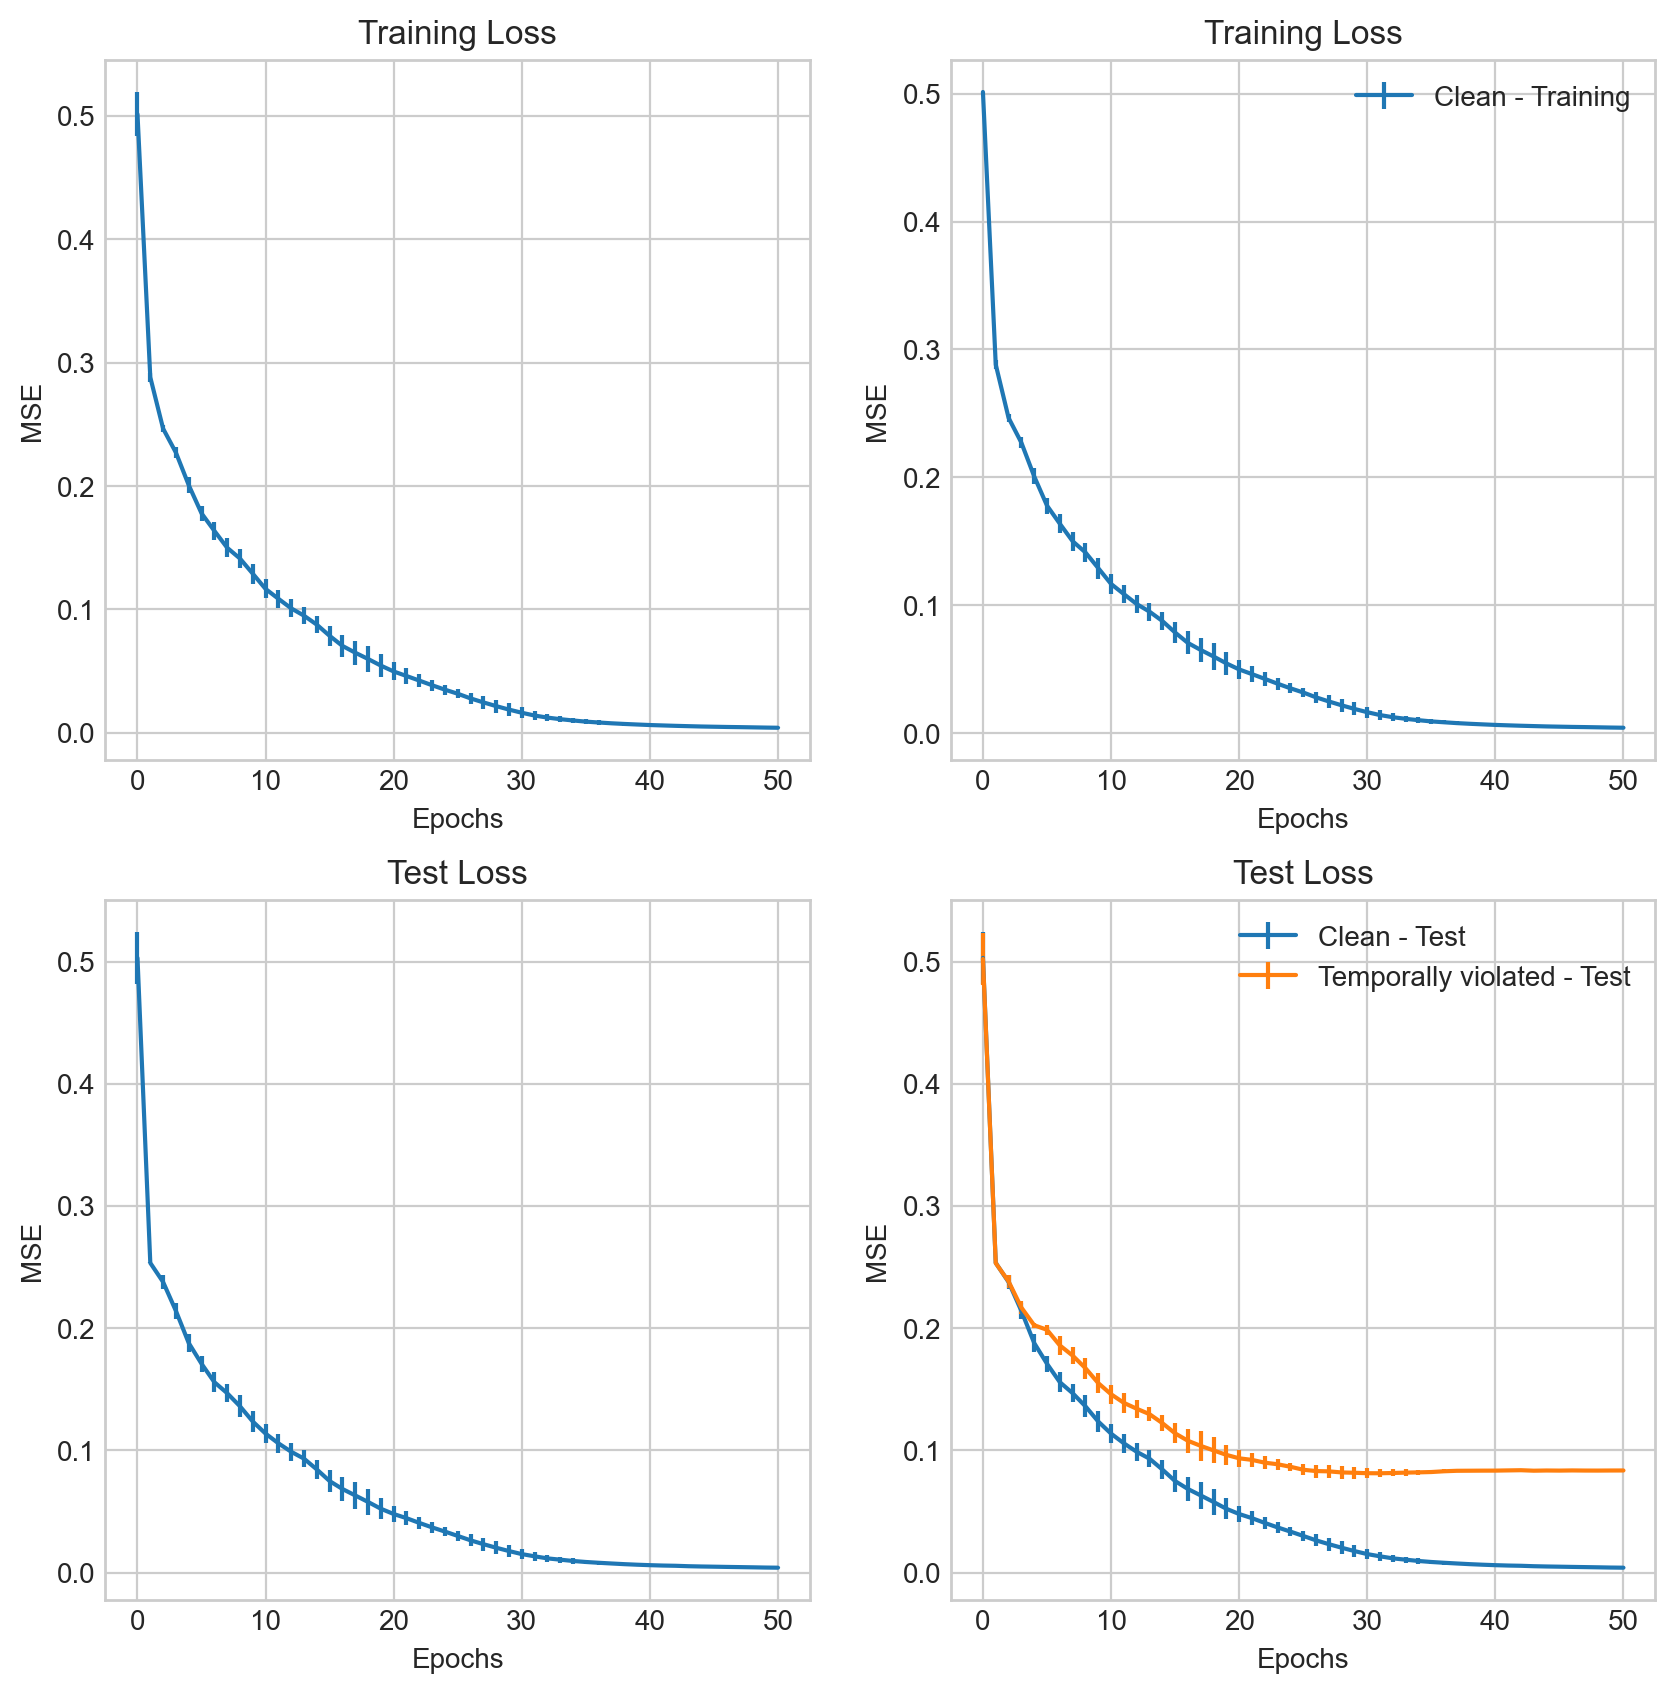

In [48]:
f = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.errorbar(np.arange(n_epochs+1),train_losses_mean,yerr=train_losses_std)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,2)
plt.errorbar(np.arange(n_epochs+1),train_expected_losses_mean,yerr=train_expected_losses_std,label='Clean - Training')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2,2,3)
plt.errorbar(np.arange(n_epochs+1),test_losses_mean,yerr=test_losses_std)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(2,2,4)
plt.errorbar(np.arange(n_epochs+1),test_expected_losses_mean,yerr=test_expected_losses_std,label='Clean - Test')
plt.errorbar(np.arange(n_epochs+1),test_surprise_losses_mean,yerr=test_surprise_losses_std,label='Temporally violated - Test')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

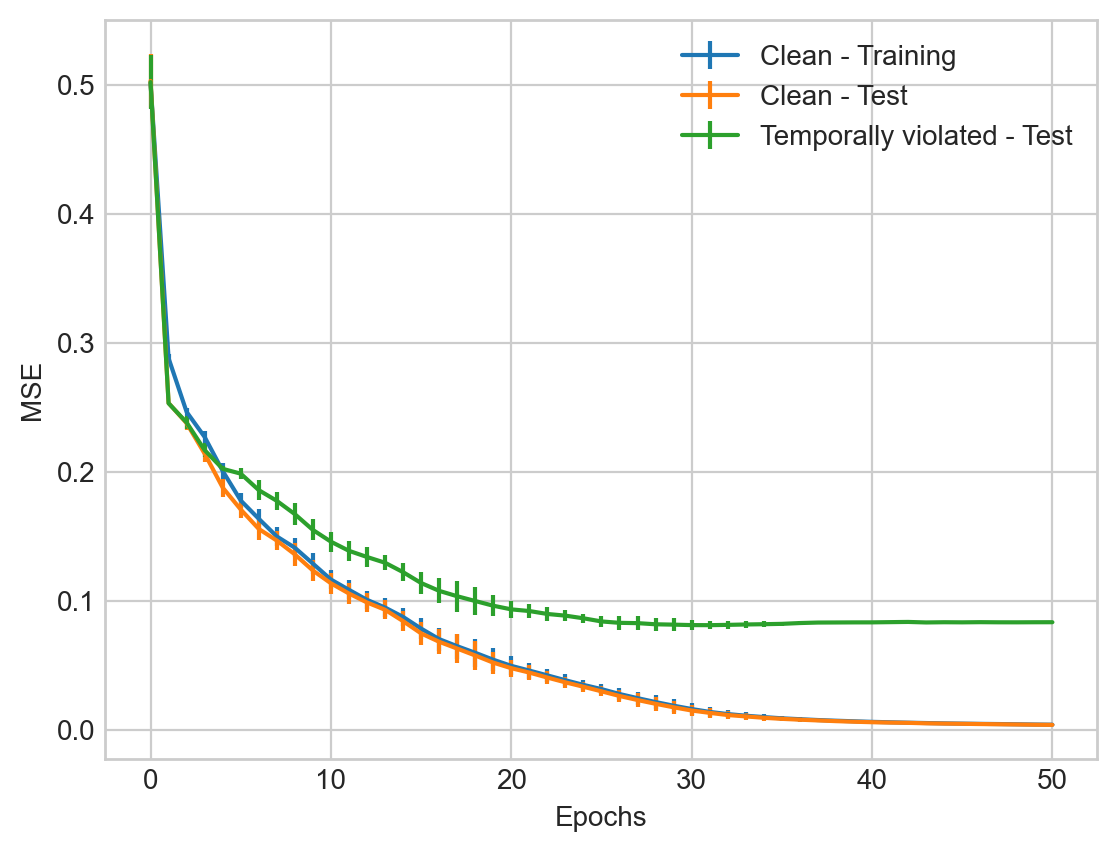

In [49]:
plt.errorbar(np.arange(n_epochs+1),train_expected_losses_mean,yerr=train_expected_losses_std,label='Clean - Training')
plt.errorbar(np.arange(n_epochs+1),test_expected_losses_mean,yerr=test_expected_losses_std,label='Clean - Test')
plt.errorbar(np.arange(n_epochs+1),test_surprise_losses_mean,yerr=test_surprise_losses_std,label='Temporally violated - Test')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [50]:
# kk=4
# a = np.unique(allStatesTest[kk][:,0])
# b = np.unique(allStatesTrain[kk][:,0])
# len(np.intersect1d(a,b))

### Representational Analyses

#### RNN Names

In [51]:
rnn_names = ['L4','L23','L56','H4','H23','H56']

#### Analyses train loader

In [52]:
analyses_train_loader = {}

In [53]:
for cntr in range(nRuns):
    analyses_train_loader[cntr] = makeTensorLoaders((repsTrain[cntr],yRepsTrain[cntr],eTrain[cntr],surpTrain[cntr]),
                                           batch_size,shuffle=False)

#### Pass data and store activations

In [54]:
def pass_data_store_activations(loader, nData, 
                                nRuns=nRuns, n_epochs=n_epochs, nSteps=nSteps, pop_list=pop_list, n_latent=n_latent,
                                batch_size = batch_size):
    
    model = {}
    
    activations_hidden_L23_np = {}
    activations_hidden_L4_np = {}
    activations_hidden_L56_np = {}

    activations_hidden_H23_np = {}
    activations_hidden_H4_np = {}
    activations_hidden_H56_np = {}

    activations_out_np = {}
    
    for cntr in range(nRuns):
        activations_hidden_L23_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
        activations_hidden_L4_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
        activations_hidden_L56_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

        activations_hidden_H23_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
        activations_hidden_H4_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
        activations_hidden_H56_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

        activations_out_np[cntr] = np.zeros((n_epochs+1,nData,nSteps,dim))
        
        for e in tqdm(range(n_epochs+1)):

            cnt = 0

            ## Load model
            model[cntr] = microcircuit(n_features=dim,hidden_dim=n_latent,bsize=batch_size,manual_seed=seeds[cntr])
            model[cntr].to(device)
            model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
            model[cntr].eval()

            ## Pass clean samples
            for data, f_target, lastEvent, surpriseBinary in loader[cntr]:

                if train_on_gpu:
                    data, f_targetC = data.float().cuda(), f_target.float().cuda()
                else: data, f_targetC = data.float(), f_target.float()

                target = f_target

                output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data)

                ## Collect activations  
                act_hidden_L23 = np.squeeze(RNN_outputs[0].detach().cpu().numpy())
                act_hidden_L4 = np.squeeze(RNN_outputs[1].detach().cpu().numpy())
                act_hidden_L56 = np.squeeze(RNN_outputs[2].detach().cpu().numpy())

                act_hidden_H23 = np.squeeze(RNN_outputs[3].detach().cpu().numpy())
                act_hidden_H4 = np.squeeze(RNN_outputs[4].detach().cpu().numpy())
                act_hidden_H56 = np.squeeze(RNN_outputs[5].detach().cpu().numpy())

                output_pred = np.squeeze(output_pred.detach().cpu().numpy())

                for i in range(batch_size):
                    if i < len(data):
                        label = target.data[i]

                        activations_hidden_L23_np[cntr][e,cnt] = act_hidden_L23[i]
                        activations_hidden_L4_np[cntr][e,cnt] = act_hidden_L4[i]
                        activations_hidden_L56_np[cntr][e,cnt] = act_hidden_L56[i]

                        activations_hidden_H23_np[cntr][e,cnt] = act_hidden_H23[i]
                        activations_hidden_H4_np[cntr][e,cnt] = act_hidden_H4[i]
                        activations_hidden_H56_np[cntr][e,cnt] = act_hidden_H56[i]

                        activations_out_np[cntr][e,cnt] = output_pred[i]

                        cnt += 1

    return (activations_hidden_L23_np,activations_hidden_L4_np,activations_hidden_L56_np,
            activations_hidden_H23_np,activations_hidden_H4_np,activations_hidden_H56_np), activations_out_np

In [55]:
# (L23_train,L4_train,L56_train,
#  H23_train,H4_train,H56_train,), out_train = pass_data_store_activations(analyses_train_loader, nTrain)

In [56]:
(L23_test,L4_test,L56_test,
 H23_test,H4_test,H56_test,), out_test = pass_data_store_activations(test_loader, nTest)

100%|██████████| 51/51 [00:27<00:00,  1.85it/s]


In [57]:
(L23_temp,L4_temp,L56_temp,
 H23_temp,H4_temp,H56_temp,), out_temp = pass_data_store_activations(test_temp_loader, nTest)

100%|██████████| 51/51 [00:27<00:00,  1.85it/s]


#### PCA for RNNs

In [58]:
def repsPCA(rnnActs):
    nEpochs, nSeqs, nRolls, nNeurons = rnnActs.shape
    pca_dict = {}
    nSamps = nSeqs*nRolls
    dimPCA = min(nNeurons,nSamps)
    repsR_transformed = np.zeros((nEpochs,nSamps,dimPCA))
    
    for ep in tqdm(range(nEpochs)):
        
        reps = rnnActs[ep]
        
        ## reshape
        repsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        for ii in range(nSeqs):
            for jj in range(nRolls):
                repsR[cnt] = reps[ii,jj]
                cnt += 1
        ## PCA
        rnnPCA = PCA()
        repsR_transformed[ep] = rnnPCA.fit_transform(repsR)
        pca_dict[str(ep)] = rnnPCA
        
    return repsR_transformed, pca_dict

In [59]:
# L23pca_train = {}
# L4pca_train = {}
# L56pca_train = {}

# H23pca_train = {}
# H4pca_train = {}
# H56pca_train = {}

L23pca_test = {}
L4pca_test = {}
L56pca_test = {}

H23pca_test = {}
H4pca_test = {}
H56pca_test = {}

L23pca_temp = {}
L4pca_temp = {}
L56pca_temp = {}

H23pca_temp = {}
H4pca_temp = {}
H56pca_temp = {}

In [60]:
# for cntr in range(nRuns):
#     L23pca_train[cntr], _ = repsPCA(L23_train[cntr])
#     L4pca_train[cntr], _ = repsPCA(L4_train[cntr])
#     L56pca_train[cntr], _ = repsPCA(L56_train[cntr])

#     H23pca_train[cntr], _ = repsPCA(H23_train[cntr])
#     H4pca_train[cntr], _ = repsPCA(H4_train[cntr])
#     H56pca_train[cntr], _ = repsPCA(H56_train[cntr])

In [61]:
for cntr in range(nRuns):
    L23pca_test[cntr], _ = repsPCA(L23_test[cntr])
    L4pca_test[cntr], _ = repsPCA(L4_test[cntr])
    L56pca_test[cntr], _ = repsPCA(L56_test[cntr])

    H23pca_test[cntr], _ = repsPCA(H23_test[cntr])
    H4pca_test[cntr], _ = repsPCA(H4_test[cntr])
    H56pca_test[cntr], _ = repsPCA(H56_test[cntr])

100%|██████████| 51/51 [00:02<00:00, 18.22it/s]


In [62]:
for cntr in range(nRuns):
    L23pca_temp[cntr], _ = repsPCA(L23_temp[cntr])
    L4pca_temp[cntr], _ = repsPCA(L4_temp[cntr])
    L56pca_temp[cntr], _ = repsPCA(L56_temp[cntr])

    H23pca_temp[cntr], _ = repsPCA(H23_temp[cntr])
    H4pca_temp[cntr], _ = repsPCA(H4_temp[cntr])
    H56pca_temp[cntr], _ = repsPCA(H56_temp[cntr])

100%|██████████| 51/51 [00:02<00:00, 19.73it/s]


In [63]:
idxs0_train = np.array([6*x for x in range(nTrain)])
idxs1_train = idxs0_train + 1
idxs2_train = idxs0_train + 2
idxs3_train = idxs0_train + 3
idxs4_train = idxs0_train + 4
idxs5_train = idxs0_train + 5

In [64]:
idxs0_test = np.array([6*x for x in range(nTest)])
idxs1_test = idxs0_test + 1
idxs2_test = idxs0_test + 2
idxs3_test = idxs0_test + 3
idxs4_test = idxs0_test + 4
idxs5_test = idxs0_test + 5

In [65]:
# cnt = 4
# ep = -1
# ix = idxs5_train
# c = allStatesTrain[cnt][:,0]/numM
# s = 20*c

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_train[cnt][ep,ix,0],L4pca_train[cnt][ep,ix,1],
#             c=allStatesTrain[cnt][:,0],s=s,cmap='Blues')
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_train[cnt][ep,ix,0],L23pca_train[cnt][ep,ix,1],
#             c=allStatesTrain[cnt][:,0],s=s,cmap='Blues')
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_train[cnt][ep,ix,0],L56pca_train[cnt][ep,ix,1],
#             c=allStatesTrain[cnt][:,0],s=s,cmap='Blues')
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_train[cnt][ep,ix,0],H4pca_train[cnt][ep,ix,1],
#             c=allStatesTrain[cnt][:,0],s=s,cmap='Blues')
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_train[cnt][ep,ix,0],H23pca_train[cnt][ep,ix,1],
#             c=allStatesTrain[cnt][:,0],s=s,cmap='Blues')
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_train[cnt][ep,ix,0],H56pca_train[cnt][ep,ix,1],
#             c=allStatesTrain[cnt][:,0],s=s,cmap='Blues')
# plt.title('Layer H5/6')

In [66]:
# cnt = 4
# ep = 50
# ix = idxs4_test
# c = allStatesTest[cnt][:,0]/numM
# s = 20*c

# f = plt.figure(figsize=(16,10))

# plt.subplot(231)
# plt.scatter(L4pca_test[cnt][ep,ix,0],L4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(L4pca_temp[cnt][ep,ix,0],L4pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer L4')

# plt.subplot(232)
# plt.scatter(L23pca_test[cnt][ep,ix,0],L23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(L23pca_temp[cnt][ep,ix,0],L23pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer L2/3')

# plt.subplot(233)
# plt.scatter(L56pca_test[cnt][ep,ix,0],L56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(L56pca_temp[cnt][ep,ix,0],L56pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer L5/6')

# plt.subplot(234)
# plt.scatter(H4pca_test[cnt][ep,ix,0],H4pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(H4pca_temp[cnt][ep,ix,0],H4pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer H4')

# plt.subplot(235)
# plt.scatter(H23pca_test[cnt][ep,ix,0],H23pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(H23pca_temp[cnt][ep,ix,0],H23pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer H2/3')

# plt.subplot(236)
# plt.scatter(H56pca_test[cnt][ep,ix,0],H56pca_test[cnt][ep,ix,1],
#             c=c,s=s,cmap='Greens')
# plt.scatter(H56pca_temp[cnt][ep,ix,0],H56pca_temp[cnt][ep,ix,1],
#             c=c,s=s,cmap='Purples')
# plt.title('Layer H5/6')

#### Subset indices, etc.

In [67]:
idxs00_train = np.hstack((idxs0_train.reshape(-1,1),idxs1_train.reshape(-1,1)))
idxs11_train = np.hstack((idxs2_train.reshape(-1,1),idxs3_train.reshape(-1,1)))
idxs22_train = np.hstack((idxs4_train.reshape(-1,1),idxs5_train.reshape(-1,1)))

In [68]:
idxs00_test = np.hstack((idxs0_test.reshape(-1,1),idxs1_test.reshape(-1,1))).ravel()
idxs11_test = np.hstack((idxs2_test.reshape(-1,1),idxs3_test.reshape(-1,1))).ravel()
idxs22_test = np.hstack((idxs4_test.reshape(-1,1),idxs5_test.reshape(-1,1))).ravel()

In [69]:
cleanPCs = {}
surpPCs = {}

contextPCs_sub = {}

In [70]:
for cntr in range(nRuns):
    cleanPCs[cntr] = (L4pca_test[cntr],L23pca_test[cntr],L56pca_test[cntr],
                      H4pca_test[cntr],H23pca_test[cntr],H56pca_test[cntr])
    surpPCs[cntr] = (L4pca_temp[cntr],L23pca_temp[cntr],L56pca_temp[cntr],
                     H4pca_temp[cntr],H23pca_temp[cntr],H56pca_temp[cntr])
    
    for rnnNo in range(len(rnn_names)):
        contextPCs_sub[cntr,rnnNo] = np.hstack((cleanPCs[cntr][rnnNo][:,idxs22_test,:],surpPCs[cntr][rnnNo][:,idxs22_test,:]))

In [71]:
context_sub_surp = np.array([0]*nRepeats*nTest + [1]*nRepeats*nTest)

In [72]:
context_sub_imgIDs = {}
for cntr in range(nRuns):
    context_sub_imgIDs[cntr] = np.hstack((np.repeat(labelsTest[cntr][:,2:3],nRepeats),
                                          np.repeat(labelsTestTemp[cntr][:,2:3],nRepeats)))

#### Supervised Decoding

In [73]:
sub_Eps = np.array([0,1,50])
ds_im = 100

In [74]:
def repsDecodeSupervisedContext(rnnActs,labels,decodeType='surprise',clf='logistic',sub=True,ds=ds_im):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    if decodeType == 'surprise':
        nClasses = 2
    elif decodeType == 'imageID':
        if sub:
            rnnActs = rnnActs[:,::ds,:]
            nEpochs, nSamps, nNeurons = rnnActs.shape
            labels = labels[::ds]
            nClasses = len(np.unique(labels))
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression(multi_class='ovr').fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)    
        
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [75]:
dims23 = np.array([1,2,4,8,16,32,64,80])
dims4 = np.array([1,2,4,8,16,32])
dims56 = np.array([1,2,4,8,16,32,64])

In [76]:
L23surpPC = {}
L4surpPC = {}
L56surpPC = {}

H23surpPC = {}
H4surpPC = {}
H56surpPC = {}

In [77]:
for cntr in tqdm(range(nRuns)):
    for d in dims23:
        L23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][sub_Eps,:,:d],context_sub_surp,decodeType='surprise')
        H23surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][sub_Eps,:,:d],context_sub_surp,decodeType='surprise')
        
    for d in dims4:
        L4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][sub_Eps,:,:d],context_sub_surp,decodeType='surprise')
        H4surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][sub_Eps,:,:d],context_sub_surp,decodeType='surprise')
    
    for d in dims56:
        L56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][sub_Eps,:,:d],context_sub_surp,decodeType='surprise')
        H56surpPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][sub_Eps,:,:d],context_sub_surp,decodeType='surprise')

100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


In [78]:
L23imgPC = {}
L4imgPC = {}
L56imgPC = {}

H23imgPC = {}
H4imgPC = {}
H56imgPC = {}

In [79]:
for cntr in tqdm(range(nRuns)):
    for d in dims23:
        L23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,1][sub_Eps,:,:d],
                                                           context_sub_imgIDs[cntr].ravel(),decodeType='imageID')
        H23imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,4][sub_Eps,:,:d],
                                                           context_sub_imgIDs[cntr].ravel(),decodeType='imageID')
        
    for d in dims4:
        L4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,0][sub_Eps,:,:d],
                                                          context_sub_imgIDs[cntr].ravel(),decodeType='imageID')
        H4imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,3][sub_Eps,:,:d],
                                                          context_sub_imgIDs[cntr].ravel(),decodeType='imageID')
    
    for d in dims56:
        L56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,2][sub_Eps,:,:d],
                                                           context_sub_imgIDs[cntr].ravel(),decodeType='imageID')
        H56imgPC[cntr,d], _ = repsDecodeSupervisedContext(contextPCs_sub[cntr,5][sub_Eps,:,:d],
                                                           context_sub_imgIDs[cntr].ravel(),decodeType='imageID')

100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


#### Generate plots

In [80]:
preds_L23imgPC = {}
preds_L4imgPC = {}
preds_L56imgPC = {}

preds_H23imgPC = {}
preds_H4imgPC = {}
preds_H56imgPC = {}

preds_L23surpPC = {}
preds_L4surpPC = {}
preds_L56surpPC = {}

preds_H23surpPC = {}
preds_H4surpPC = {}
preds_H56surpPC = {}

In [81]:
accs_L23imgPC = {}
accs_L4imgPC = {}
accs_L56imgPC = {}

accs_H23imgPC = {}
accs_H4imgPC = {}
accs_H56imgPC = {}

accs_L23surpPC = {}
accs_L4surpPC = {}
accs_L56surpPC = {}

accs_H23surpPC = {}
accs_H4surpPC = {}
accs_H56surpPC = {}

In [84]:
for cntr in range(nRuns):
    for ep in range(len(sub_Eps)):
        
        for d in dims23:
            preds_L23imgPC[cntr,d,ep] = np.argmax(L23imgPC[cntr,d][ep],axis=-1)
            preds_H23imgPC[cntr,d,ep] = np.argmax(H23imgPC[cntr,d][ep],axis=-1)
            
            preds_L23surpPC[cntr,d,ep] = np.argmax(L23surpPC[cntr,d][ep],axis=-1)
            preds_H23surpPC[cntr,d,ep] = np.argmax(H23surpPC[cntr,d][ep],axis=-1)
            
            accs_L23imgPC[cntr,d,ep] = homogeneity_score(context_sub_imgIDs[cntr][::ds_im],preds_L23imgPC[cntr,d,ep])
            accs_H23imgPC[cntr,d,ep] = homogeneity_score(context_sub_imgIDs[cntr][::ds_im],preds_H23imgPC[cntr,d,ep])
            
            accs_L23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L23surpPC[cntr,d,ep])
            accs_H23surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H23surpPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4imgPC[cntr,d,ep] = np.argmax(L4imgPC[cntr,d][ep],axis=-1)
            preds_H4imgPC[cntr,d,ep] = np.argmax(H4imgPC[cntr,d][ep],axis=-1)
            
            preds_L4surpPC[cntr,d,ep] = np.argmax(L4surpPC[cntr,d][ep],axis=-1)
            preds_H4surpPC[cntr,d,ep] = np.argmax(H4surpPC[cntr,d][ep],axis=-1)
            
            accs_L4imgPC[cntr,d,ep] = homogeneity_score(context_sub_imgIDs[cntr][::ds_im],preds_L4imgPC[cntr,d,ep])
            accs_H4imgPC[cntr,d,ep] = homogeneity_score(context_sub_imgIDs[cntr][::ds_im],preds_H4imgPC[cntr,d,ep])
            
            accs_L4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L4surpPC[cntr,d,ep])
            accs_H4surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H4surpPC[cntr,d,ep])
                
        for d in dims56:        
            preds_L56imgPC[cntr,d,ep] = np.argmax(L56imgPC[cntr,d][ep],axis=-1)
            preds_H56imgPC[cntr,d,ep] = np.argmax(H56imgPC[cntr,d][ep],axis=-1)
            
            preds_L56surpPC[cntr,d,ep] = np.argmax(L56surpPC[cntr,d][ep],axis=-1)
            preds_H56surpPC[cntr,d,ep] = np.argmax(H56surpPC[cntr,d][ep],axis=-1)
            
            accs_L56imgPC[cntr,d,ep] = homogeneity_score(context_sub_imgIDs[cntr][::ds_im],preds_L56imgPC[cntr,d,ep])
            accs_H56imgPC[cntr,d,ep] = homogeneity_score(context_sub_imgIDs[cntr][::ds_im],preds_H56imgPC[cntr,d,ep])
            
            accs_L56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_L56surpPC[cntr,d,ep])
            accs_H56surpPC[cntr,d,ep] = accuracy_score(context_sub_surp,preds_H56surpPC[cntr,d,ep])
            

In [85]:
tensor_accs_L23imgPC = np.zeros((nRuns,len(dims23),len(sub_Eps)))
tensor_accs_L4imgPC = np.zeros((nRuns,len(dims4),len(sub_Eps)))
tensor_accs_L56imgPC = np.zeros((nRuns,len(dims56),len(sub_Eps)))

tensor_accs_H23imgPC = np.zeros((nRuns,len(dims23),len(sub_Eps)))
tensor_accs_H4imgPC = np.zeros((nRuns,len(dims4),len(sub_Eps)))
tensor_accs_H56imgPC = np.zeros((nRuns,len(dims56),len(sub_Eps)))

tensor_accs_L23surpPC = np.zeros((nRuns,len(dims23),len(sub_Eps)))
tensor_accs_L4surpPC = np.zeros((nRuns,len(dims4),len(sub_Eps)))
tensor_accs_L56surpPC = np.zeros((nRuns,len(dims56),len(sub_Eps)))

tensor_accs_H23surpPC = np.zeros((nRuns,len(dims23),len(sub_Eps)))
tensor_accs_H4surpPC = np.zeros((nRuns,len(dims4),len(sub_Eps)))
tensor_accs_H56surpPC = np.zeros((nRuns,len(dims56),len(sub_Eps)))

In [86]:
for ii in range(nRuns):
    for kk in range(len(sub_Eps)):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23imgPC[ii,jj,kk] = accs_L23imgPC[ii,d,kk]
            tensor_accs_H23imgPC[ii,jj,kk] = accs_H23imgPC[ii,d,kk]
            
            tensor_accs_L23surpPC[ii,jj,kk] = accs_L23surpPC[ii,d,kk]
            tensor_accs_H23surpPC[ii,jj,kk] = accs_H23surpPC[ii,d,kk]
            
        
        for jj,d in enumerate(dims4):
            tensor_accs_L4imgPC[ii,jj,kk] = accs_L4imgPC[ii,d,kk]
            tensor_accs_H4imgPC[ii,jj,kk] = accs_H4imgPC[ii,d,kk]
            
            tensor_accs_L4surpPC[ii,jj,kk] = accs_L4surpPC[ii,d,kk]
            tensor_accs_H4surpPC[ii,jj,kk] = accs_H4surpPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56imgPC[ii,jj,kk] = accs_L56imgPC[ii,d,kk]
            tensor_accs_H56imgPC[ii,jj,kk] = accs_H56imgPC[ii,d,kk]

            tensor_accs_L56surpPC[ii,jj,kk] = accs_L56surpPC[ii,d,kk]
            tensor_accs_H56surpPC[ii,jj,kk] = accs_H56surpPC[ii,d,kk]

In [87]:
mean_accs_L4imgPC = np.zeros((len(dims4),len(sub_Eps)))
mean_accs_L23imgPC = np.zeros((len(dims23),len(sub_Eps)))
mean_accs_L56imgPC = np.zeros((len(dims56),len(sub_Eps)))

mean_accs_H4imgPC = np.zeros((len(dims4),len(sub_Eps)))
mean_accs_H23imgPC = np.zeros((len(dims23),len(sub_Eps)))
mean_accs_H56imgPC = np.zeros((len(dims56),len(sub_Eps)))

mean_accs_L4surpPC = np.zeros((len(dims4),len(sub_Eps)))
mean_accs_L23surpPC = np.zeros((len(dims23),len(sub_Eps)))
mean_accs_L56surpPC = np.zeros((len(dims56),len(sub_Eps)))

mean_accs_H4surpPC = np.zeros((len(dims4),len(sub_Eps)))
mean_accs_H23surpPC = np.zeros((len(dims23),len(sub_Eps)))
mean_accs_H56surpPC = np.zeros((len(dims56),len(sub_Eps)))

std_accs_L4imgPC = np.zeros((len(dims4),len(sub_Eps)))
std_accs_L23imgPC = np.zeros((len(dims23),len(sub_Eps)))
std_accs_L56imgPC = np.zeros((len(dims56),len(sub_Eps)))

std_accs_H4imgPC = np.zeros((len(dims4),len(sub_Eps)))
std_accs_H23imgPC = np.zeros((len(dims23),len(sub_Eps)))
std_accs_H56imgPC = np.zeros((len(dims56),len(sub_Eps)))

std_accs_L4surpPC = np.zeros((len(dims4),len(sub_Eps)))
std_accs_L23surpPC = np.zeros((len(dims23),len(sub_Eps)))
std_accs_L56surpPC = np.zeros((len(dims56),len(sub_Eps)))

std_accs_H4surpPC = np.zeros((len(dims4),len(sub_Eps)))
std_accs_H23surpPC = np.zeros((len(dims23),len(sub_Eps)))
std_accs_H56surpPC = np.zeros((len(dims56),len(sub_Eps)))

In [88]:
for ep in range(len(sub_Eps)):
    
    for dd, dims in enumerate(dims23):
        mean_accs_L23imgPC[dd,ep] = np.mean(tensor_accs_L23imgPC[:,dd,ep])
        mean_accs_H23imgPC[dd,ep] = np.mean(tensor_accs_H23imgPC[:,dd,ep])
        
        std_accs_L23imgPC[dd,ep] = np.var(tensor_accs_L23imgPC[:,dd,ep])
        std_accs_H23imgPC[dd,ep] = np.var(tensor_accs_H23imgPC[:,dd,ep])
        
        mean_accs_L23surpPC[dd,ep] = np.mean(tensor_accs_L23surpPC[:,dd,ep])
        mean_accs_H23surpPC[dd,ep] = np.mean(tensor_accs_H23surpPC[:,dd,ep])
        
        std_accs_L23surpPC[dd,ep] = np.var(tensor_accs_L23surpPC[:,dd,ep])
        std_accs_H23surpPC[dd,ep] = np.var(tensor_accs_H23surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims4):
        mean_accs_L4imgPC[dd,ep] = np.mean(tensor_accs_L4imgPC[:,dd,ep])
        mean_accs_H4imgPC[dd,ep] = np.mean(tensor_accs_H4imgPC[:,dd,ep])
        
        std_accs_L4imgPC[dd,ep] = np.var(tensor_accs_L4imgPC[:,dd,ep])
        std_accs_H4imgPC[dd,ep] = np.var(tensor_accs_H4imgPC[:,dd,ep])
        
        mean_accs_L4surpPC[dd,ep] = np.mean(tensor_accs_L4surpPC[:,dd,ep])
        mean_accs_H4surpPC[dd,ep] = np.mean(tensor_accs_H4surpPC[:,dd,ep])
        
        std_accs_L4surpPC[dd,ep] = np.var(tensor_accs_L4surpPC[:,dd,ep])
        std_accs_H4surpPC[dd,ep] = np.var(tensor_accs_H4surpPC[:,dd,ep])
        
    for dd, dims in enumerate(dims56):
        mean_accs_L56imgPC[dd,ep] = np.mean(tensor_accs_L56imgPC[:,dd,ep])        
        mean_accs_H56imgPC[dd,ep] = np.mean(tensor_accs_H56imgPC[:,dd,ep])
        
        std_accs_L56imgPC[dd,ep] = np.var(tensor_accs_L56imgPC[:,dd,ep])
        std_accs_H56imgPC[dd,ep] = np.var(tensor_accs_H56imgPC[:,dd,ep])
        
        mean_accs_L56surpPC[dd,ep] = np.mean(tensor_accs_L56surpPC[:,dd,ep])
        mean_accs_H56surpPC[dd,ep] = np.mean(tensor_accs_H56surpPC[:,dd,ep])
        
        std_accs_L56surpPC[dd,ep] = np.var(tensor_accs_L56surpPC[:,dd,ep])        
        std_accs_H56surpPC[dd,ep] = np.var(tensor_accs_H56surpPC[:,dd,ep])

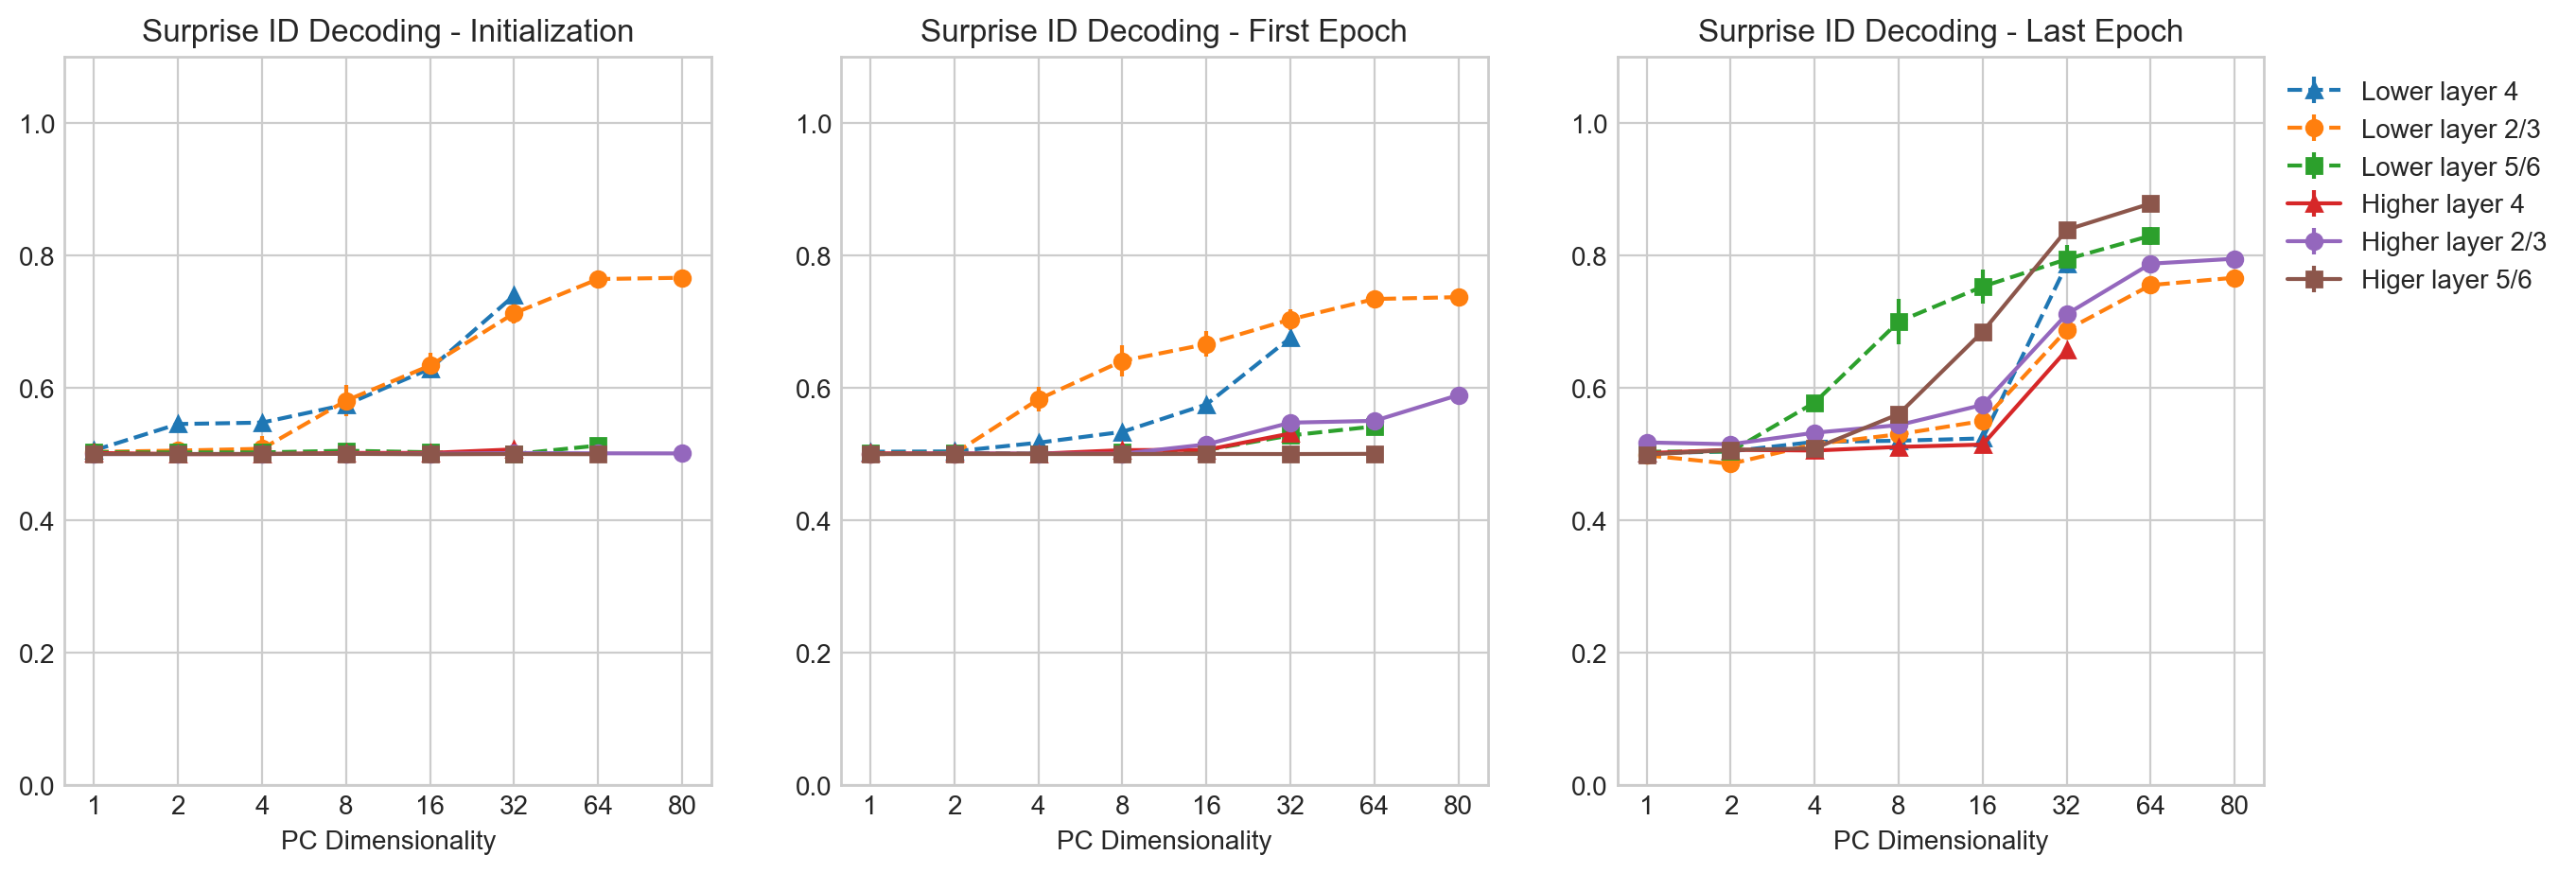

In [89]:
ffsurp_dim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Surprise ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,0],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,0],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,0],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,0],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,0],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,0],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(132)
plt.title('Surprise ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,1],yerr=std_accs_L4surpPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,1],yerr=std_accs_L23surpPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,1],yerr=std_accs_L56surpPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,1],yerr=std_accs_H4surpPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,1],yerr=std_accs_H23surpPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,1],yerr=std_accs_H56surpPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
# plt.legend()

plt.subplot(133)
plt.title('Surprise ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4surpPC[:,-1],yerr=std_accs_L4surpPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23surpPC[:,-1],yerr=std_accs_L23surpPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56surpPC[:,-1],yerr=std_accs_L56surpPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4surpPC[:,-1],yerr=std_accs_H4surpPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23surpPC[:,-1],yerr=std_accs_H23surpPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56surpPC[:,-1],yerr=std_accs_H56surpPC[:,-1],label='Higer layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

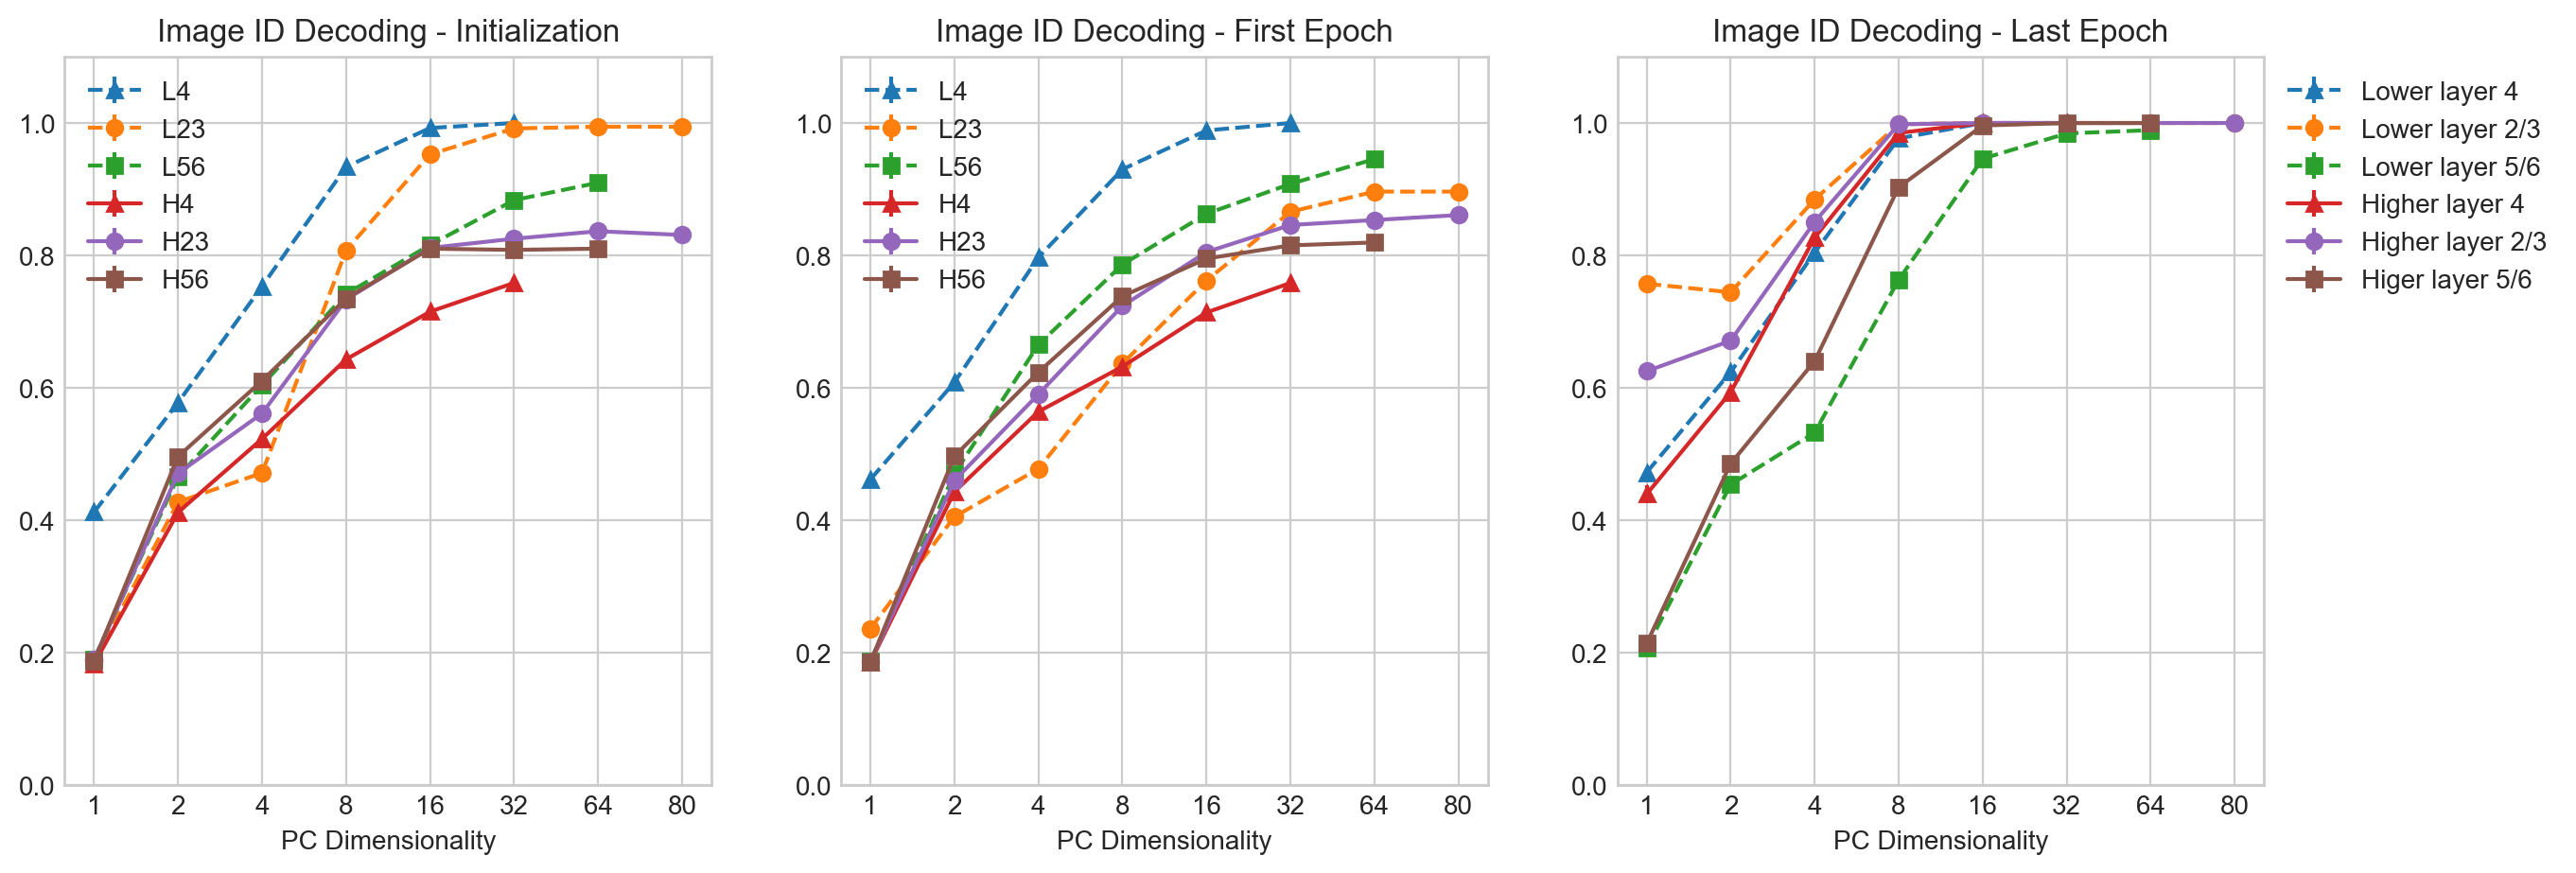

In [90]:
ffdim = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Image ID Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,0],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,0],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,0],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,0],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,0],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,0],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Image ID Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,1],yerr=std_accs_L4imgPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,1],yerr=std_accs_L23imgPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,1],yerr=std_accs_L56imgPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,1],yerr=std_accs_H4imgPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,1],yerr=std_accs_H23imgPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,1],yerr=std_accs_H56imgPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Image ID Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4imgPC[:,-1],yerr=std_accs_L4imgPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23imgPC[:,-1],yerr=std_accs_L23imgPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56imgPC[:,-1],yerr=std_accs_L56imgPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4imgPC[:,-1],yerr=std_accs_H4imgPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23imgPC[:,-1],yerr=std_accs_H23imgPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56imgPC[:,-1],yerr=std_accs_H56imgPC[:,-1],label='Higer layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

#### Position

In [91]:
step_labels = np.array([x%nSteps for x in range(nTest*nSteps)])

In [92]:
def repsDecodeSupervisedPosition(rnnActs,labels,clf='logistic'):
    nEpochs, nSamps, nNeurons = rnnActs.shape
    decode_dict = {}
    
    nClasses = 6
    
    reps_preds_probs = np.zeros((nEpochs,nSamps,nClasses))
    
    for ep in (range(nEpochs)):
        repsR = rnnActs[ep]
        
        ## Decoding
        if clf=='svm':
            clfR = SVC(kernel='linear',probability=True).fit(repsR,labels)
        elif clf=='logistic':
            clfR = LogisticRegression().fit(repsR,labels)
        elif clf=='perceptron':
            clfR = Perceptron().fit(repsR,labels)
        
        reps_preds_probs[ep] = clfR.predict_proba(repsR)
        decode_dict[str(ep)] = clfR
        
    return reps_preds_probs, decode_dict

In [93]:
L4posPC = {}
L23posPC = {}
L56posPC = {}
H4posPC = {}
H23posPC = {}
H56posPC = {}

In [94]:
for cntr in tqdm(range(nRuns)):
    
    for d in dims23:
        L23posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][1][sub_Eps,:,:d],step_labels)
        H23posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][4][sub_Eps,:,:d],step_labels)
    
    for d in dims4:
        L4posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][0][sub_Eps,:,:d],step_labels)
        H4posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][3][sub_Eps,:,:d],step_labels)
        
    for d in dims56:
        ## Position
        L56posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][2][sub_Eps,:,:d],step_labels)      
        H56posPC[cntr,d], _ = repsDecodeSupervisedPosition(cleanPCs[cntr][5][sub_Eps,:,:d],step_labels)

100%|██████████| 5/5 [01:24<00:00, 16.84s/it]


In [95]:
preds_L23posPC = {}
preds_L4posPC = {}
preds_L56posPC = {}

preds_H23posPC = {}
preds_H4posPC = {}
preds_H56posPC = {}

In [96]:
accs_L23posPC = {}
accs_L4posPC = {}
accs_L56posPC = {}

accs_H23posPC = {}
accs_H4posPC = {}
accs_H56posPC = {}

In [97]:
for cntr in range(nRuns):
    
    for ep in range(len(sub_Eps)):
        
        for d in dims23:
            preds_L23posPC[cntr,d,ep] = np.argmax(L23posPC[cntr,d][ep],axis=-1)
            preds_H23posPC[cntr,d,ep] = np.argmax(H23posPC[cntr,d][ep],axis=-1)
            
            accs_L23posPC[cntr,d,ep] = accuracy_score(step_labels,preds_L23posPC[cntr,d,ep])
            accs_H23posPC[cntr,d,ep] = accuracy_score(step_labels,preds_H23posPC[cntr,d,ep])
            
        for d in dims4:
            preds_L4posPC[cntr,d,ep] = np.argmax(L4posPC[cntr,d][ep],axis=-1)
            preds_H4posPC[cntr,d,ep] = np.argmax(H4posPC[cntr,d][ep],axis=-1)
            
            accs_L4posPC[cntr,d,ep] = accuracy_score(step_labels,preds_L4posPC[cntr,d,ep])
            accs_H4posPC[cntr,d,ep] = accuracy_score(step_labels,preds_H4posPC[cntr,d,ep])
            
        for d in dims56:
            preds_L56posPC[cntr,d,ep] = np.argmax(L56posPC[cntr,d][ep],axis=-1)
            preds_H56posPC[cntr,d,ep] = np.argmax(H56posPC[cntr,d][ep],axis=-1)
            
            accs_L56posPC[cntr,d,ep] = accuracy_score(step_labels,preds_L56posPC[cntr,d,ep])
            accs_H56posPC[cntr,d,ep] = accuracy_score(step_labels,preds_H56posPC[cntr,d,ep])

In [98]:
tensor_accs_L23posPC = np.zeros((nRuns,len(dims23),len(sub_Eps)))
tensor_accs_L4posPC = np.zeros((nRuns,len(dims4),len(sub_Eps)))
tensor_accs_L56posPC = np.zeros((nRuns,len(dims56),len(sub_Eps)))

tensor_accs_H23posPC = np.zeros((nRuns,len(dims23),len(sub_Eps)))
tensor_accs_H4posPC = np.zeros((nRuns,len(dims4),len(sub_Eps)))
tensor_accs_H56posPC = np.zeros((nRuns,len(dims56),len(sub_Eps)))

In [99]:
for ii in range(nRuns):
    
    for kk in range(len(sub_Eps)):
        
        for jj,d in enumerate(dims23):
            tensor_accs_L23posPC[ii,jj,kk] = accs_L23posPC[ii,d,kk]
            tensor_accs_H23posPC[ii,jj,kk] = accs_H23posPC[ii,d,kk]
            
        for jj,d in enumerate(dims4):
            tensor_accs_L4posPC[ii,jj,kk] = accs_L4posPC[ii,d,kk]
            tensor_accs_H4posPC[ii,jj,kk] = accs_H4posPC[ii,d,kk]
            
        for jj,d in enumerate(dims56):            
            tensor_accs_L56posPC[ii,jj,kk] = accs_L56posPC[ii,d,kk]            
            tensor_accs_H56posPC[ii,jj,kk] = accs_H56posPC[ii,d,kk]

In [100]:
mean_accs_L4posPC = np.zeros((len(dims4),len(sub_Eps)))
mean_accs_L23posPC = np.zeros((len(dims23),len(sub_Eps)))
mean_accs_L56posPC = np.zeros((len(dims56),len(sub_Eps)))

mean_accs_H4posPC = np.zeros((len(dims4),len(sub_Eps)))
mean_accs_H23posPC = np.zeros((len(dims23),len(sub_Eps)))
mean_accs_H56posPC = np.zeros((len(dims56),len(sub_Eps)))

std_accs_L4posPC = np.zeros((len(dims4),len(sub_Eps)))
std_accs_L23posPC = np.zeros((len(dims23),len(sub_Eps)))
std_accs_L56posPC = np.zeros((len(dims56),len(sub_Eps)))

std_accs_H4posPC = np.zeros((len(dims4),len(sub_Eps)))
std_accs_H23posPC = np.zeros((len(dims23),len(sub_Eps)))
std_accs_H56posPC = np.zeros((len(dims56),len(sub_Eps)))

In [101]:
for ep in range(len(sub_Eps)):
    
    for dd, dim in enumerate(dims23):
        mean_accs_L23posPC[dd,ep] = np.mean(tensor_accs_L23posPC[:,dd,ep])
        mean_accs_H23posPC[dd,ep] = np.mean(tensor_accs_H23posPC[:,dd,ep])
        
        std_accs_L23posPC[dd,ep] = np.var(tensor_accs_L23posPC[:,dd,ep])
        std_accs_H23posPC[dd,ep] = np.var(tensor_accs_H23posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims4):
        mean_accs_L4posPC[dd,ep] = np.mean(tensor_accs_L4posPC[:,dd,ep])
        mean_accs_H4posPC[dd,ep] = np.mean(tensor_accs_H4posPC[:,dd,ep])
        
        std_accs_L4posPC[dd,ep] = np.var(tensor_accs_L4posPC[:,dd,ep])
        std_accs_H4posPC[dd,ep] = np.var(tensor_accs_H4posPC[:,dd,ep])
        
    for dd, dim in enumerate(dims56):
        mean_accs_L56posPC[dd,ep] = np.mean(tensor_accs_L56posPC[:,dd,ep])
        mean_accs_H56posPC[dd,ep] = np.mean(tensor_accs_H56posPC[:,dd,ep])
        
        std_accs_L56posPC[dd,ep] = np.var(tensor_accs_L56posPC[:,dd,ep])
        std_accs_H56posPC[dd,ep] = np.var(tensor_accs_H56posPC[:,dd,ep])

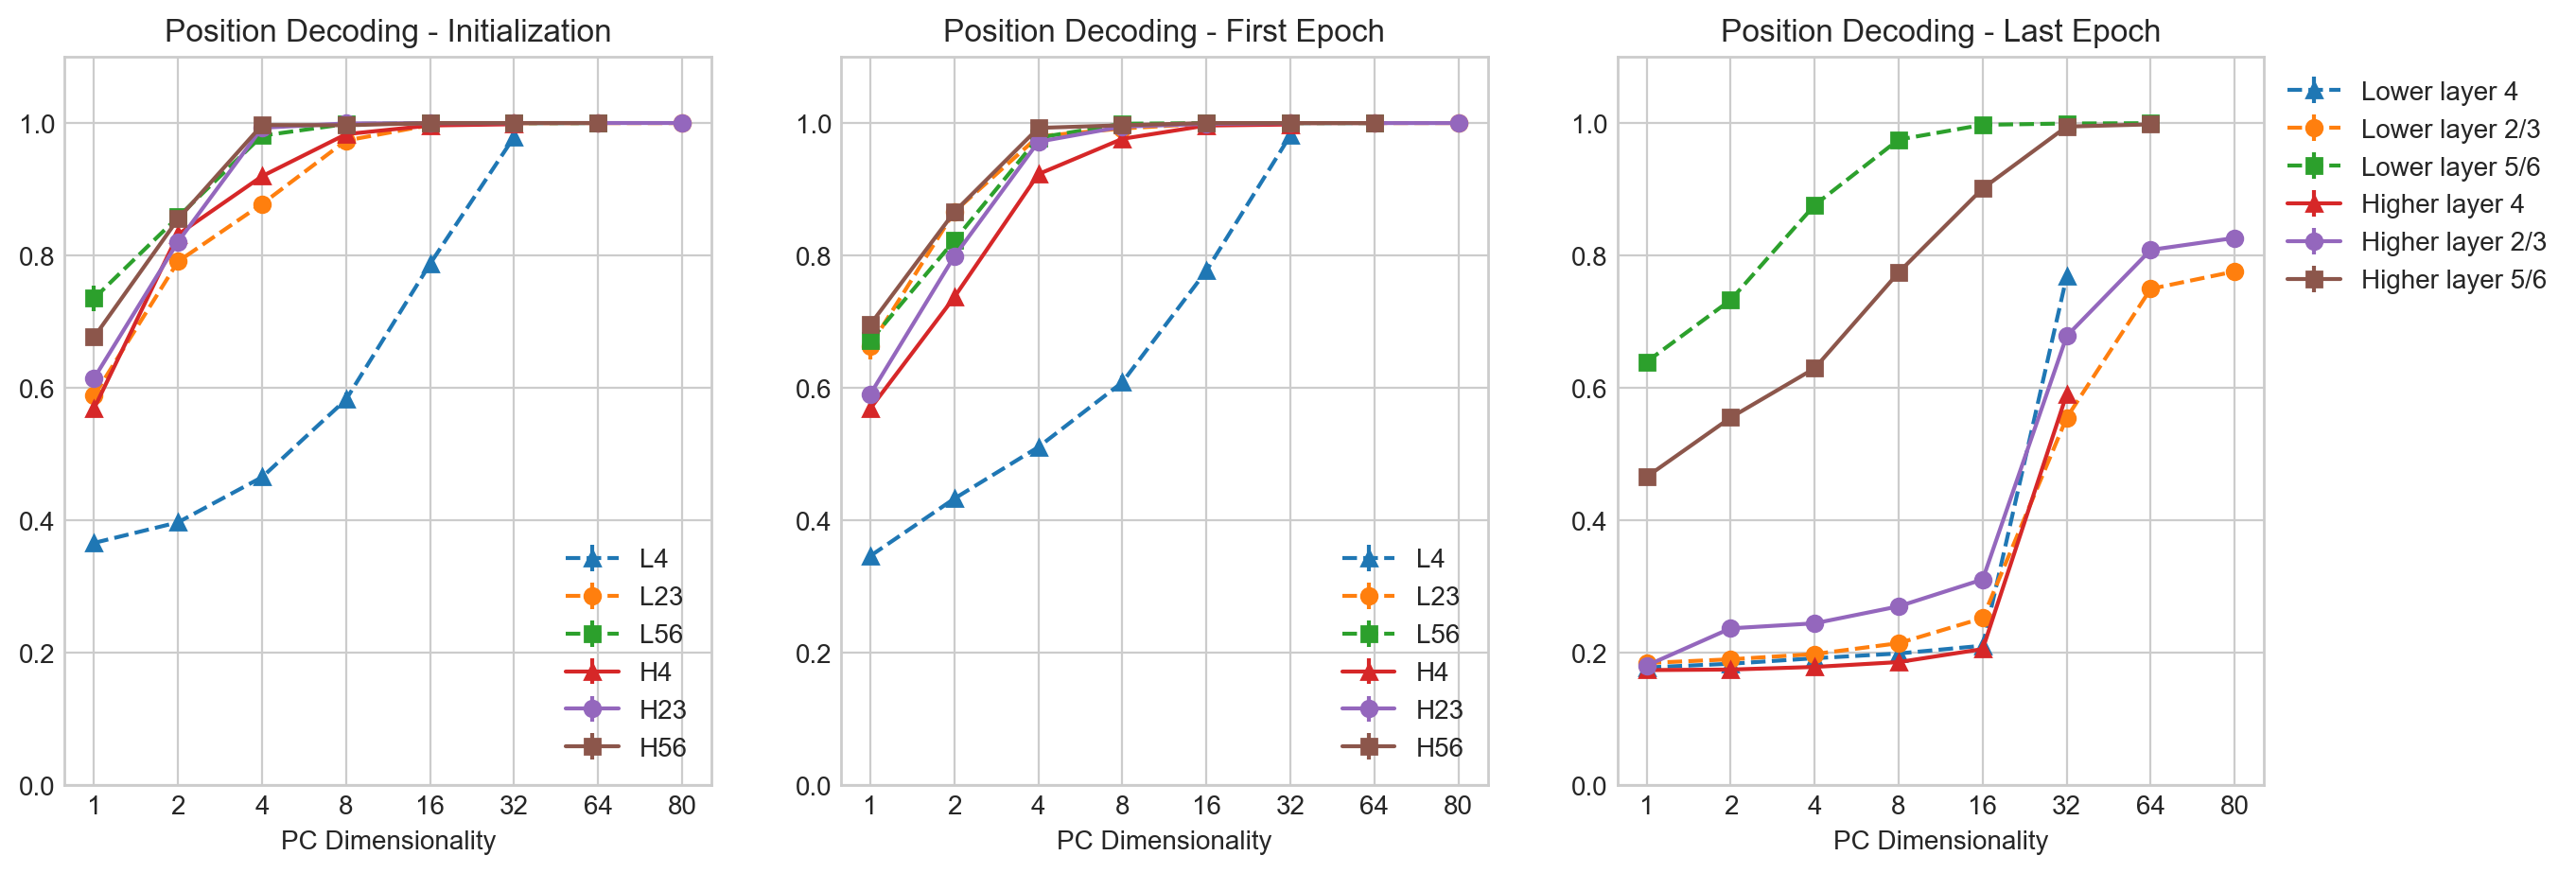

In [102]:
ffpos = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Position Decoding - Initialization')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,0],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,0],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,0],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,0],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,0],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,0],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(132)
plt.title('Position Decoding - First Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,1],yerr=std_accs_L4posPC[:,1],label='L4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,1],yerr=std_accs_L23posPC[:,1],label='L23',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,1],yerr=std_accs_L56posPC[:,1],label='L56',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,1],yerr=std_accs_H4posPC[:,1],label='H4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,1],yerr=std_accs_H23posPC[:,1],label='H23',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,1],yerr=std_accs_H56posPC[:,1],label='H56',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend()

plt.subplot(133)
plt.title('Position Decoding - Last Epoch')
plt.errorbar(np.arange(len(dims4)),mean_accs_L4posPC[:,-1],yerr=std_accs_L4posPC[:,-1],label='Lower layer 4',fmt='--^')
plt.errorbar(np.arange(len(dims23)),mean_accs_L23posPC[:,-1],yerr=std_accs_L23posPC[:,-1],label='Lower layer 2/3',fmt='--o')
plt.errorbar(np.arange(len(dims56)),mean_accs_L56posPC[:,-1],yerr=std_accs_L56posPC[:,-1],label='Lower layer 5/6',fmt='--s')
plt.errorbar(np.arange(len(dims4)),mean_accs_H4posPC[:,-1],yerr=std_accs_H4posPC[:,-1],label='Higher layer 4',fmt='-^')
plt.errorbar(np.arange(len(dims23)),mean_accs_H23posPC[:,-1],yerr=std_accs_H23posPC[:,-1],label='Higher layer 2/3',fmt='-o')
plt.errorbar(np.arange(len(dims56)),mean_accs_H56posPC[:,-1],yerr=std_accs_H56posPC[:,-1],label='Higher layer 5/6',fmt='-s')
plt.xlabel('PC Dimensionality')
plt.ylim(0,1.1)
plt.xticks(np.arange(len(dims23)),dims23)
plt.legend(bbox_to_anchor=(1,1))

In [103]:
np.save(pp+'preds_img_temp_L4-unidirectional-fb-binary',preds_L4imgPC)
np.save(pp+'preds_img_temp_L23-unidirectional-fb-binary',preds_L23imgPC)
np.save(pp+'preds_img_temp_L56-unidirectional-fb-binary',preds_L56imgPC)
np.save(pp+'preds_img_temp_H4-unidirectional-fb-binary',preds_H4imgPC)
np.save(pp+'preds_img_temp_H23-unidirectional-fb-binary',preds_H23imgPC)
np.save(pp+'preds_img_temp_H56-unidirectional-fb-binary',preds_H56imgPC)

np.save(pp+'accs_img_temp_L4-unidirectional-fb-binary',accs_L4imgPC)
np.save(pp+'accs_img_temp_L23-unidirectional-fb-binary',accs_L23imgPC)
np.save(pp+'accs_img_temp_L56-unidirectional-fb-binary',accs_L56imgPC)
np.save(pp+'accs_img_temp_H4-unidirectional-fb-binary',accs_H4imgPC)
np.save(pp+'accs_img_temp_H23-unidirectional-fb-binary',accs_H23imgPC)
np.save(pp+'accs_img_temp_H56-unidirectional-fb-binary',accs_H56imgPC)

In [104]:
np.save(pp+'preds_pos_temp_L4-unidirectional-fb-binary',preds_L4posPC)
np.save(pp+'preds_pos_temp_L23-unidirectional-fb-binary',preds_L23posPC)
np.save(pp+'preds_pos_temp_L56-unidirectional-fb-binary',preds_L56posPC)
np.save(pp+'preds_pos_temp_H4-unidirectional-fb-binary',preds_H4posPC)
np.save(pp+'preds_pos_temp_H23-unidirectional-fb-binary',preds_H23posPC)
np.save(pp+'preds_pos_temp_H56-unidirectional-fb-binary',preds_H56posPC)

np.save(pp+'accs_pos_temp_L4-unidirectional-fb-binary',accs_L4posPC)
np.save(pp+'accs_pos_temp_L23-unidirectional-fb-binary',accs_L23posPC)
np.save(pp+'accs_pos_temp_L56-unidirectional-fb-binary',accs_L56posPC)
np.save(pp+'accs_pos_temp_H4-unidirectional-fb-binary',accs_H4posPC)
np.save(pp+'accs_pos_temp_H23-unidirectional-fb-binary',accs_H23posPC)
np.save(pp+'accs_pos_temp_H56-unidirectional-fb-binary',accs_H56posPC)

In [105]:
np.save(pp+'preds_surp_temp_L4-unidirectional-fb',preds_L4surpPC)
np.save(pp+'preds_surp_temp_L23-unidirectional-fb',preds_L23surpPC)
np.save(pp+'preds_surp_temp_L56-unidirectional-fb',preds_L56surpPC)
np.save(pp+'preds_surp_temp_H4-unidirectional-fb',preds_H4surpPC)
np.save(pp+'preds_surp_temp_H23-unidirectional-fb',preds_H23surpPC)
np.save(pp+'preds_surp_temp_H56-unidirectional-fb',preds_H56surpPC)

np.save(pp+'accs_surp_temp_L4-unidirectional-fb',accs_L4surpPC)
np.save(pp+'accs_surp_temp_L23-unidirectional-fb',accs_L23surpPC)
np.save(pp+'accs_surp_temp_L56-unidirectional-fb',accs_L56surpPC)
np.save(pp+'accs_surp_temp_H4-unidirectional-fb',accs_H4surpPC)
np.save(pp+'accs_surp_temp_H23-unidirectional-fb',accs_H23surpPC)
np.save(pp+'accs_surp_temp_H56-unidirectional-fb',accs_H56surpPC)

#### Temporal accuracies

In [106]:
preds_test = {}
preds_temp = {}

accs_test = np.zeros((nRuns,n_epochs+1))
accs_temp = np.zeros((nRuns,n_epochs+1))

for cntr in range(nRuns):
    preds_test[cntr] = np.abs(np.round_(out_test[cntr]*(out_test[cntr]>0)))
    preds_temp[cntr] = np.abs(np.round_(out_test[cntr]*(out_temp[cntr]>0)))
    
    accs_test[cntr] = np.sum(np.sum(np.sum(((yRepsTest[cntr] - preds_test[cntr])==0)*1,-1),-1),-1)/np.prod(yRepsTest[cntr].shape)
    accs_temp[cntr] = np.sum(np.sum(np.sum(((yRepsTestTemp[cntr] - preds_temp[cntr])==0)*1,-1),-1),-1)/np.prod(yRepsTestTemp[cntr].shape)

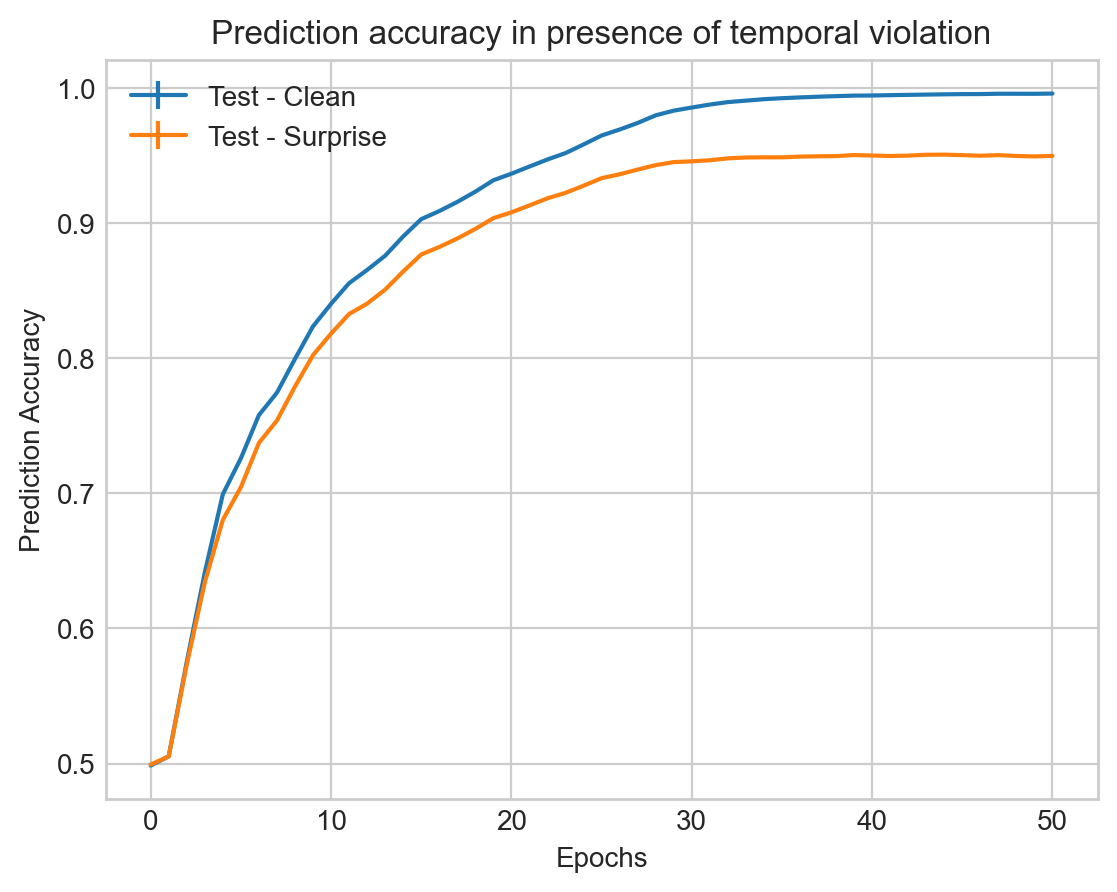

In [107]:
ff_final_temp_noise = plt.figure()
plt.errorbar(np.arange(n_epochs+1),np.mean(accs_test,0),yerr=np.var(accs_test,0),fmt='-',label='Test - Clean')
plt.errorbar(np.arange(n_epochs+1),np.mean(accs_temp,0),yerr=np.var(accs_temp,0),fmt='-',label='Test - Surprise')
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
plt.legend()
plt.title('Prediction accuracy in presence of temporal violation')
plt.show()

In [108]:
np.save(pp+'unidirectional-fb-no-violations-accs-binary',accs_test)
np.save(pp+'unidirectional-fb-temporal-violations-accs-binary',accs_temp)

In [109]:
ff_final_temp_noise.savefig('temporal-violation-final-acc-repeated-runs-unidirectional-fb-bianry.png',dpi=300,bbox_inches='tight')
ff_final_temp_noise.savefig('temporal-violation-final-acc-repeated-runs-unidirectional-fb-binary.svg',dpi=300,bbox_inches='tight')

#### Spatial violations

In [110]:
dim = 16

In [111]:
from numpy.random import normal

In [112]:
noise_stds = np.linspace(0,5,6)

In [113]:
noiseSeqs = {}

In [114]:
for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        noiseSeqs[cntr,nn] = repsTest[cntr] + normal(0,noise,repsTest[cntr].shape)

In [115]:
noisy_loader_analyses = {}

for cntr in range(nRuns):
    for nn, noise in enumerate(noise_stds):
        noisy_loader_analyses[cntr,nn] = makeTensorLoaders((noiseSeqs[cntr,nn],yRepsTest[cntr],eTest[cntr],surpTest[cntr]),
                                          batch_size,shuffle=False)

In [116]:
L23_noisy = {}
L4_noisy = {}
L56_noisy = {}

H23_noisy = {}
H4_noisy = {}
H56_noisy = {}

out_noisy = {}

In [117]:
def pass_data_store_noisy_activations(loader, nData, 
                                nRuns=nRuns, n_epochs=n_epochs, nSteps=nSteps, pop_list=pop_list, n_latent=n_latent,
                                batch_size = batch_size):
    
    model = {}
    
    activations_hidden_L23_np = {}
    activations_hidden_L4_np = {}
    activations_hidden_L56_np = {}

    activations_hidden_H23_np = {}
    activations_hidden_H4_np = {}
    activations_hidden_H56_np = {}

    activations_out_np = {}
    
    for cntr in range(nRuns):
        for nn in range(len(noise_stds)):
            activations_hidden_L23_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
            activations_hidden_L4_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
            activations_hidden_L56_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

            activations_hidden_H23_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[1]*n_latent))
            activations_hidden_H4_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[0]*n_latent))
            activations_hidden_H56_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,pop_list[2]*n_latent))

            activations_out_np[cntr,nn] = np.zeros((n_epochs+1,nData,nSteps,dim))

            for e in tqdm(range(n_epochs+1)):

                cnt = 0

                ## Load model
                model[cntr] = microcircuit(n_features=dim,hidden_dim=n_latent,bsize=batch_size,manual_seed=seeds[cntr])
                model[cntr].to(device)
                model[cntr].load_state_dict(torch.load(pp_pts[cntr]+'predRNN_epoch_'+str(e)+'.pt'))
                model[cntr].eval()

                ## Pass clean samples
                for data, f_target, lastEvent, surpriseBinary in loader[cntr,nn]:

                    if train_on_gpu:
                        data, f_targetC = data.float().cuda(), f_target.float().cuda()
                    else: data, f_targetC = data.float(), f_target.float()

                    target = f_target

                    output_pred, RNN_outputs, feedbackDiffs, projInterArea = model[cntr](data)

                    ## Collect activations  
                    act_hidden_L23 = np.squeeze(RNN_outputs[0].detach().cpu().numpy())
                    act_hidden_L4 = np.squeeze(RNN_outputs[1].detach().cpu().numpy())
                    act_hidden_L56 = np.squeeze(RNN_outputs[2].detach().cpu().numpy())

                    act_hidden_H23 = np.squeeze(RNN_outputs[3].detach().cpu().numpy())
                    act_hidden_H4 = np.squeeze(RNN_outputs[4].detach().cpu().numpy())
                    act_hidden_H56 = np.squeeze(RNN_outputs[5].detach().cpu().numpy())

                    output_pred = np.squeeze(output_pred.detach().cpu().numpy())

                    for i in range(batch_size):
                        if i < len(data):
                            label = target.data[i]

                            activations_hidden_L23_np[cntr,nn][e,cnt] = act_hidden_L23[i]
                            activations_hidden_L4_np[cntr,nn][e,cnt] = act_hidden_L4[i]
                            activations_hidden_L56_np[cntr,nn][e,cnt] = act_hidden_L56[i]

                            activations_hidden_H23_np[cntr,nn][e,cnt] = act_hidden_H23[i]
                            activations_hidden_H4_np[cntr,nn][e,cnt] = act_hidden_H4[i]
                            activations_hidden_H56_np[cntr,nn][e,cnt] = act_hidden_H56[i]

                            activations_out_np[cntr,nn][e,cnt] = output_pred[i]

                            cnt += 1

    return (activations_hidden_L23_np,activations_hidden_L4_np,activations_hidden_L56_np,
            activations_hidden_H23_np,activations_hidden_H4_np,activations_hidden_H56_np), activations_out_np

In [118]:
(L23_noisy,L4_noisy,L56_noisy,
 H23_noisy,H4_noisy,H56_noisy,), out_noisy = pass_data_store_noisy_activations(noisy_loader_analyses, nTest)

100%|██████████| 51/51 [00:27<00:00,  1.82it/s]


In [119]:
predsN = {}
accsN = np.zeros((nRuns,len(noise_stds),n_epochs+1))

In [120]:
for cntr in range(nRuns):
    for nn in range(len(noise_stds)):
        predsN[cntr,nn] = np.abs(np.round_(out_noisy[cntr,nn]*(out_noisy[cntr,nn]>0)))
        accsN[cntr,nn] = np.sum(np.sum(np.sum(((yRepsTest[cntr] - predsN[cntr,nn])==0)*1,-1),-1),-1)/np.prod(yRepsTest[cntr].shape)

In [122]:
name = "Dark2_r"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

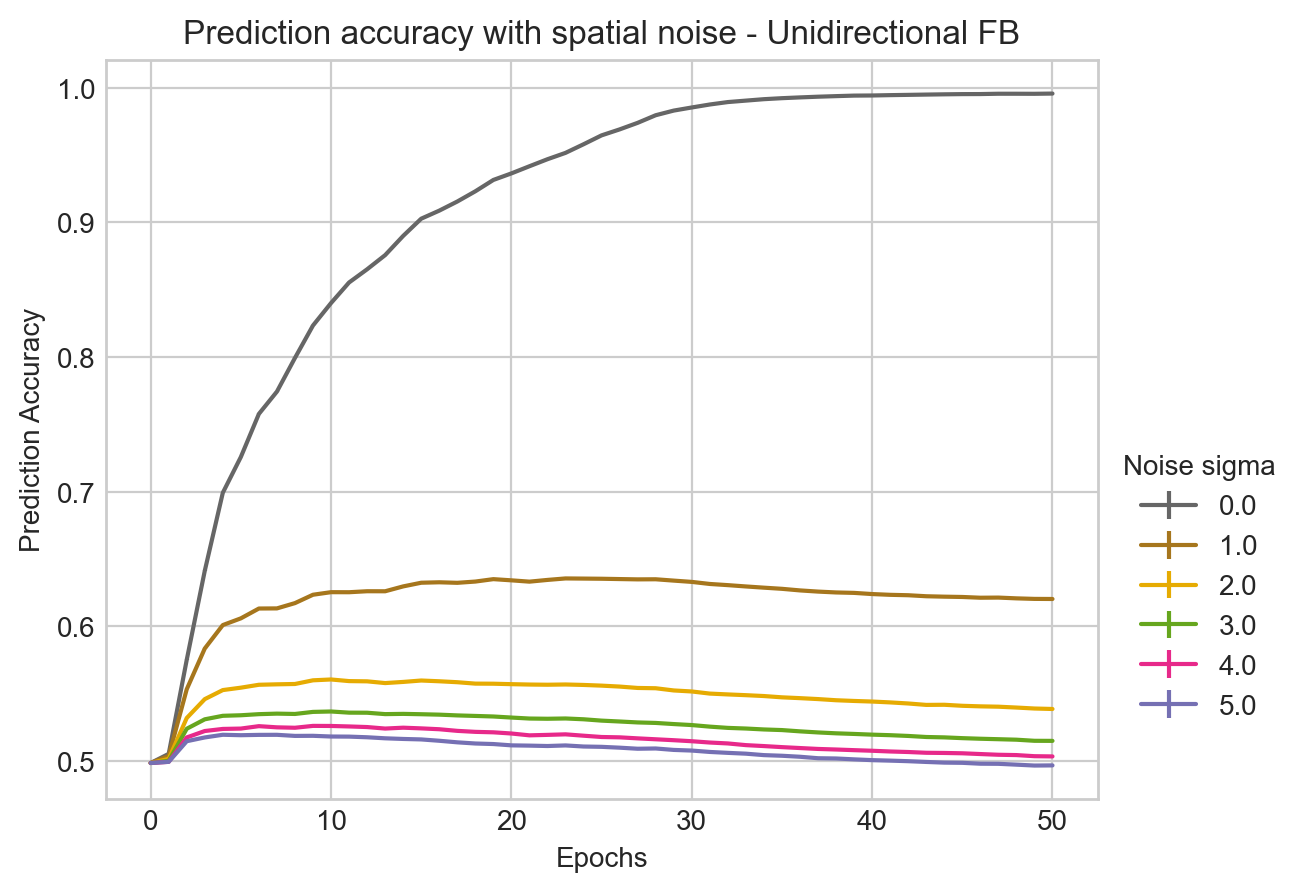

In [123]:
fpredspat = plt.figure()
for nn, noise in enumerate(noise_stds):
    plt.errorbar(np.arange(n_epochs+1),np.mean(accsN[:,nn],0),yerr=np.var(accsN[:,nn],0),fmt='-',label=np.round(noise,2),
                 c=colors[nn])
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
# plt.ylim(0,1)
plt.legend(title="Noise sigma",bbox_to_anchor=(1,0.5))
plt.title('Prediction accuracy with spatial noise - Unidirectional FB')
plt.show()

In [124]:
np.save(pp+'unidirectional-fb-spatial-noisy-accs-binary',accsN)

#### Dimensionality (Linear)

In [125]:
def rnnLinDim(acts):
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    eig_mat = np.zeros((nEpochs,nNeurons))
        
    for ep in tqdm(range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
        cov = actsScaled.T@actsScaled
        eig_mat[ep] = eigvals(cov)
        num = np.sum(eig_mat,1)**2
        den = np.sum(eig_mat**2,1) + 1e-17
        PR = num/den
    return PR

In [126]:
L23LinDim = np.zeros((nRuns,n_epochs+1))
L4LinDim = np.zeros((nRuns,n_epochs+1))
L56LinDim = np.zeros((nRuns,n_epochs+1))

H23LinDim = np.zeros((nRuns,n_epochs+1))
H4LinDim = np.zeros((nRuns,n_epochs+1))
H56LinDim = np.zeros((nRuns,n_epochs+1))

In [127]:
for cntr in range(nRuns):
    L23LinDim[cntr] = rnnLinDim(L23_test[cntr])
    L4LinDim[cntr] = rnnLinDim(L4_test[cntr])
    L56LinDim[cntr] = rnnLinDim(L56_test[cntr])

    H23LinDim[cntr] = rnnLinDim(H23_test[cntr])
    H4LinDim[cntr] = rnnLinDim(H4_test[cntr])
    H56LinDim[cntr] = rnnLinDim(H56_test[cntr])

100%|██████████| 51/51 [00:01<00:00, 34.37it/s]


#### Dimensionality (non-linear)

In [128]:
def rnnNonLinDim(acts,nTypes=2,subsample=True,ds=100):
    
    nEpochs,nSeqs, nRolls, nNeurons = acts.shape
    nSamps = nSeqs*nRolls
    
    dims_mat = np.zeros((nEpochs,nTypes))
        
    for ep in (range(nEpochs)):
        reps = acts[ep]
        
        ## reshape
        actsR = np.zeros((nSeqs*nRolls,nNeurons))
        cnt = 0
        
        for ii in range(nSeqs):
            for jj in range(nRolls):
                
                actsR[cnt] = reps[ii,jj]
                cnt += 1
        
        scaler = StandardScaler()
        actsScaled = scaler.fit_transform(actsR)
        
        if subsample:
            actsScaled = actsScaled[::ds]
        
        dims_mat[ep,0] = MiND_ML().fit(actsScaled).dimension_
#         print(dims_mat[ep,0])
        dims_mat[ep,1] = CorrInt().fit(actsScaled).dimension_
#         print(dims_mat[ep,1])
#         dims_mat[ep,2] = MLE().fit(actsScaled).dimension_
#         print(dims_mat[ep,2])
#         dims_mat[ep,3] = DANCo().fit(actsScaled).dimension_
        
    return np.mean(dims_mat,-1),dims_mat

In [129]:
L23NonLinDim = np.zeros((nRuns,n_epochs+1))
L4NonLinDim = np.zeros((nRuns,n_epochs+1))
L56NonLinDim = np.zeros((nRuns,n_epochs+1))

H23NonLinDim = np.zeros((nRuns,n_epochs+1))
H4NonLinDim = np.zeros((nRuns,n_epochs+1))
H56NonLinDim = np.zeros((nRuns,n_epochs+1))

In [130]:
L23_ND_mat = {}
L4_ND_mat = {}
L56_ND_mat = {}
H23_ND_mat = {}
H4_ND_mat = {}
H56_ND_mat = {}

In [131]:
for cntr in tqdm(range(nRuns)):
    L23NonLinDim[cntr], L23_ND_mat[cntr] = rnnNonLinDim(L23_test[cntr])
    L4NonLinDim[cntr], L4_ND_mat[cntr] = rnnNonLinDim(L4_test[cntr])
    L56NonLinDim[cntr], L56_ND_mat[cntr] = rnnNonLinDim(L56_test[cntr])

    H23NonLinDim[cntr], H23_ND_mat[cntr] = rnnNonLinDim(H23_test[cntr])
    H4NonLinDim[cntr], H4_ND_mat[cntr] = rnnNonLinDim(H4_test[cntr])
    H56NonLinDim[cntr], H56_ND_mat[cntr] = rnnNonLinDim(H56_test[cntr])

100%|██████████| 5/5 [18:46<00:00, 225.28s/it]


In [132]:
L23_NonLineDim_mean = np.mean(L23NonLinDim,0)
L4_NonLineDim_mean = np.mean(L4NonLinDim,0)
L56_NonLineDim_mean = np.mean(L56NonLinDim,0)

H23_NonLineDim_mean = np.mean(H23NonLinDim,0)
H4_NonLineDim_mean = np.mean(H4NonLinDim,0)
H56_NonLineDim_mean = np.mean(H56NonLinDim,0)

L23_NonLineDim_std = np.var(L23NonLinDim,0)
L4_NonLineDim_std = np.var(L4NonLinDim,0)
L56_NonLineDim_std = np.var(L56NonLinDim,0)

H23_NonLineDim_std = np.var(H23NonLinDim,0)
H4_NonLineDim_std = np.var(H4NonLinDim,0)
H56_NonLineDim_std = np.var(H56NonLinDim,0)

In [133]:
L23_dim = np.zeros((nRuns,n_epochs+1))
L4_dim = np.zeros((nRuns,n_epochs+1))
L56_dim = np.zeros((nRuns,n_epochs+1))

H23_dim = np.zeros((nRuns,n_epochs+1))
H4_dim = np.zeros((nRuns,n_epochs+1))
H56_dim = np.zeros((nRuns,n_epochs+1))

In [134]:
for cntr in range(nRuns):
    L23_dim[cntr] = L23LinDim[cntr]/L23NonLinDim[cntr]
    L4_dim[cntr] = L4LinDim[cntr]/L4NonLinDim[cntr]
    L56_dim[cntr] = L56LinDim[cntr]/L56NonLinDim[cntr]
    H23_dim[cntr] = H23LinDim[cntr]/H23NonLinDim[cntr]
    H4_dim[cntr] = H4LinDim[cntr]/H4NonLinDim[cntr]
    H56_dim[cntr] = H56LinDim[cntr]/H56NonLinDim[cntr]

In [135]:
np.save(pp+'L23DG_unidirectional-fb_binary',L23_dim)
np.save(pp+'L4DG_unidirectional-fb_binary',L4_dim)
np.save(pp+'L56DG_unidirectional-fb_binary',L56_dim)
np.save(pp+'H23DG_unidirectional-fb_binary',H23_dim)
np.save(pp+'H4DG_unidirectional-fb_binary',H4_dim)
np.save(pp+'H56DG_unidirectional-fb_binary',H56_dim)

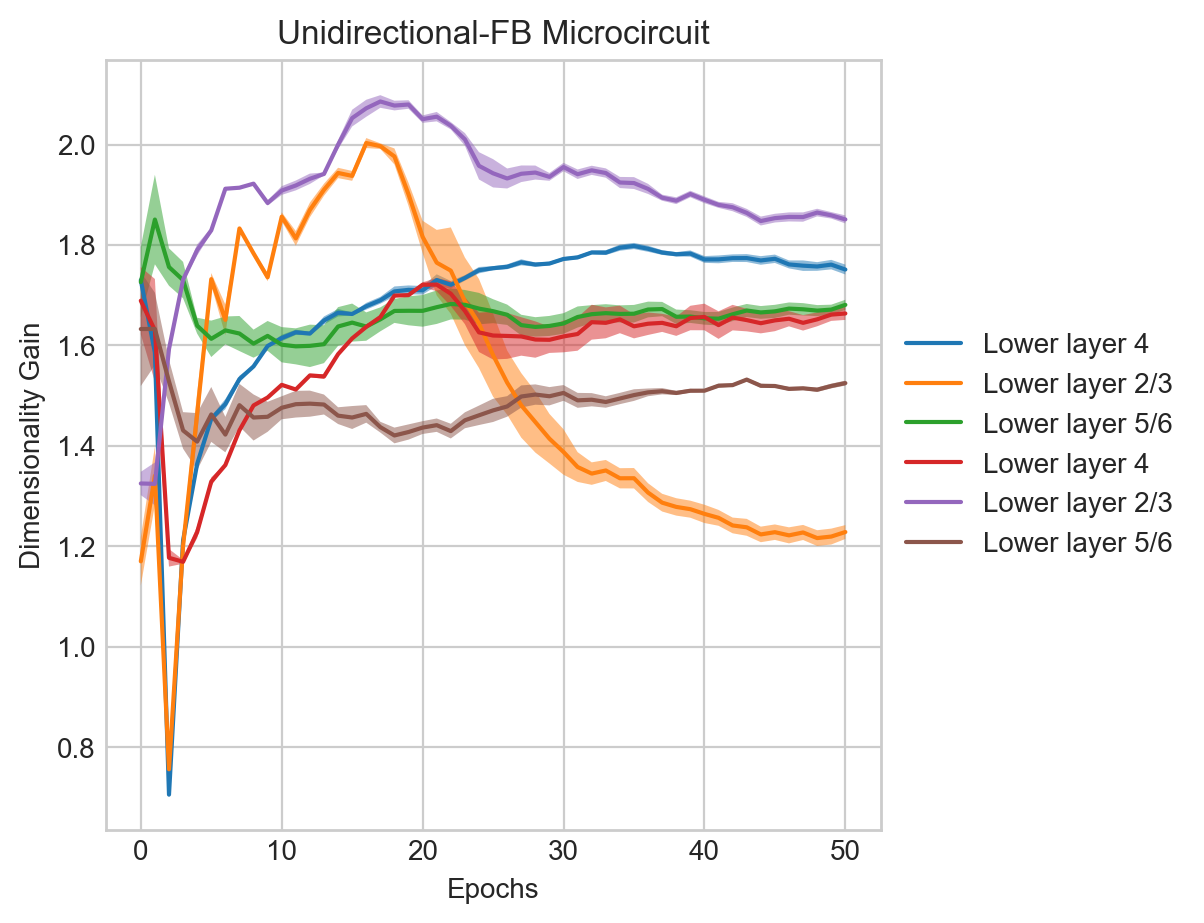

In [136]:
ffTotDim = plt.figure(figsize=(5,5))

plt.subplot(111)

plt.plot(np.arange(n_epochs+1),np.mean(L4_dim,0),label='Lower layer 4')
plt.fill_between(np.arange(n_epochs+1),np.mean(L4_dim,0)-np.var(L4_dim,0),np.mean(L4_dim,0)+np.var(L4_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(L23_dim,0),label='Lower layer 2/3')
plt.fill_between(np.arange(n_epochs+1),np.mean(L23_dim,0)-np.var(L23_dim,0),np.mean(L23_dim,0)+np.var(L23_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(L56_dim,0),label='Lower layer 5/6')
plt.fill_between(np.arange(n_epochs+1),np.mean(L56_dim,0)-np.var(L56_dim,0),np.mean(L56_dim,0)+np.var(L56_dim,0),alpha=0.5)

plt.plot(np.arange(n_epochs+1),np.mean(H4_dim,0),label='Lower layer 4')
plt.fill_between(np.arange(n_epochs+1),np.mean(H4_dim,0)-np.var(H4_dim,0),np.mean(H4_dim,0)+np.var(H4_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(H23_dim,0),label='Lower layer 2/3')
plt.fill_between(np.arange(n_epochs+1),np.mean(H23_dim,0)-np.var(H23_dim,0),np.mean(H23_dim,0)+np.var(H23_dim,0),alpha=0.5)
plt.plot(np.arange(n_epochs+1),np.mean(H56_dim,0),label='Lower layer 5/6')
plt.fill_between(np.arange(n_epochs+1),np.mean(H56_dim,0)-np.var(H56_dim,0),np.mean(H56_dim,0)+np.var(H56_dim,0),alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Dimensionality Gain')
# plt.ylim(0.9,2.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Unidirectional-FB Microcircuit')
plt.show()

In [137]:
ffTotDim.savefig('Dimensionality-gain-unidirectional-fb-across-learning-binary.png',dpi=300,bbox_inches='tight')
ffTotDim.savefig('Dimensionality-gain-unidirectional-fb-across-learning-binary.svg',dpi=300,bbox_inches='tight')